## The El Farol problem with discrete probability Q-learning and individual punishment



# The main function

Mean attendance (last 100): 67.82
Mean chosen p (last 100): 0.677


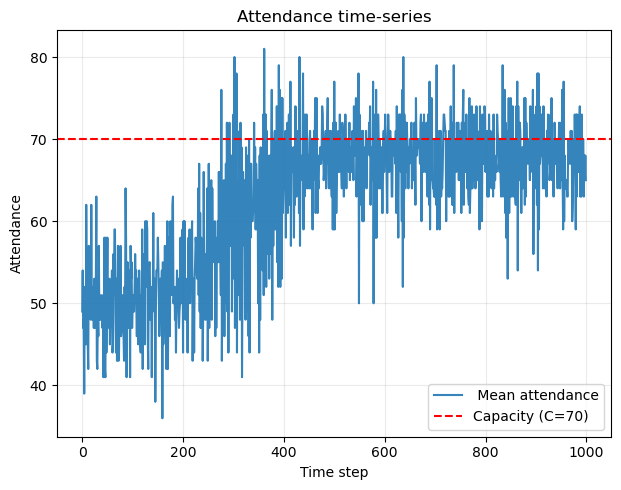

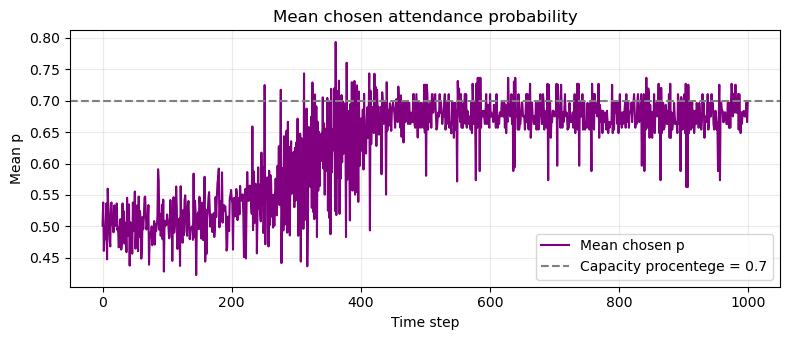

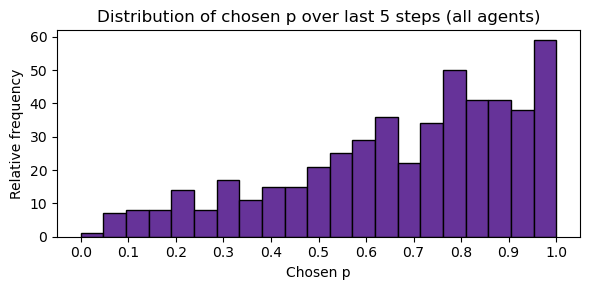

In [497]:
"""
El Farol Bar Problem 

"""

import random, math
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# PARAMETERS 
# ---------------------------------------------------------------------
# Common
SEED = 404 #golden seed 404
np.random.seed(SEED)

# Game / environment
N = 100            # number of agents
C_frac = 0.7      # capacity as fraction of population
C = int(C_frac * N)  # bar capacity
T = 1000         # number of rounds / time steps

# Payoffs
G = 8.0   # payoff for attending when not overcrowded
S = 2.0   # payoff for staying home
F = 0.5   # payoff for attending when overcrowded

# Punishment parameters
rho = 0.1 #PREV 0.1 - if rho is equal to 0.6 then some person gets negative payoff on average and the atendece because sligtly closer to the capasity
alpha = 1.3 #PREV 1.3 - this is called phi in the papper to not cofuse it with a - but i can't be bothered to change it     
theta_cap = 1000
bar_theta = 0.8
beta = 0.5  

# RL parameters
M = 20          # discretization steps: actions = 0..M (p = a/M) there will be M+1 many probability levels cus also 0
LR = 0.01       # Q-learning rate - to high learning rate means that convergens happens too quicly and all of the space in the bar might not be utilized
GAMMA = 0.7     # discount factor
K_INIT = 0.1    # initial Q value range
# ---------------------------------------------------------------------

# --- Temperature schedule parameters ---
TAU_START = 1.0      # initial exploration temperature
TAU_MIN = 0.0001       # minimal exploration


# -------------------------
# Discrete-probability RL
# -------------------------
def softmax(x, tau):
    #Boltzmann (softmax) policy, which converts Q-values into action probabilities - x is vector of q-values (consites of action and state)
    z = x / tau
    z -= np.max(z) #just numerical stability
    expz = np.exp(z) # Exponential weighting
    return expz / expz.sum() #Normalization constant (sum over all actions)


def bin_theta(theta):
    #Binning θ turns a continuous, potentially huge variable into a small, learnable categorical feature that makes Q-learning practical and stable.
    """Binning for Theta - maps the order of magnitude of theta to an integer “bin”"""
    if theta <= 0:
        return 0
    return min(int(math.log10(theta + 1e-9) + 1), 6) # ensures that the Q-tables has a discrete and hashable keys


def make_state(A):
    """State representation"""
    a_int = int(A)
    return (a_int)


def run_discrete_prob_rl(G=G, S=S, F=F, N=N, C=C, T=T, M=M, lr=LR, gamma=GAMMA,
                         tau_start=TAU_START, tau_min=TAU_MIN,
                         rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                         theta_cap=theta_cap, k_init=K_INIT, SEED=SEED):
    
    """Discrete-probability RL model"""
    Q_tables = [dict() for _ in range(N)] #makes N dicts - each maps the discreate state representet as a Q-vector of length M+1.
    last_actual = np.random.binomial(1, 0.5, size=N) #It represents the previous actions (attendance) of the agents before the simulation begins (i put 50/50)
    theta_i = np.array([bar_theta if a == 0 else 0.0 for a in last_actual], dtype=float) #if agent’s initial action was 0, set theta = bar_theta, else 0.0 for all the N actions in last_actual.
    #Theta = theta_i.sum() #just the sum used for payoff

    def q_get(qdict, s):
        #Returns the Q-vector for state s stored in qdict (an agent’s Q-table).
        #If s is absent, initializes a new random Q-vector uniformly in [0, k_init) of length M+1.

        #q_get initialises Q-values randomly in [0, k_init). This introduces stochasticity and exploration early on.

        if s not in qdict:
            qdict[s] = np.random.uniform(0, k_init, size=M + 1)
        return qdict[s]

    attendance_ts = [] #(list of attendance counts over time),
    mean_p_ts = [] #(mean of chosen probabilities each timestep),
    chosen_action_counts = np.zeros((N, M + 1), dtype=int) #(N x (M+1) counts of how many times each index chosen),
    chosen_history = np.zeros((T, N), dtype=int)  # (T x N array storing chosen indices each time step) KINDA BIG.
    attendance_var_ts = [] #new: create list of varianses
    avg_payoff_ts = []              # NEW: track average payoff each timestep
    all_payoffs = np.zeros((T, N))  # NEW: record individual payoffs each timestep
    p_var = []


    # Compute decay rate so tau(T-1) ≈ tau_min - makes sure it is not negative
    if tau_min <= 0 or tau_start <= 0:
        raise ValueError("tau_start and tau_min must be > 0")
    
    TAU_DECAY = -math.log(tau_min / tau_start) / max(1, (T - 1)) #this makes sure that they tau is reaches the min at the end of the run and not befor 
    # the line computes the exact exponential decay rate such that tau_t decreases smoothly from tau_start to tau_min across the simulation duration T.
    #this could be chanced to a fixed number 

    tau_history = [] # for plotting

    for t in range(T):
        #THE LOOP BEGINS 
        tau_t = max(tau_min, tau_start * math.exp(-TAU_DECAY * t)) #update tau acording so boltzman softmax - make exponential decreas
        tau_history.append(tau_t) #for plotting

        A_prev = attendance_ts[-1] if t > 0 else int(N * 0.1) #previous attendance (use 10% of N as initial attendance at t=0). WHY 0.1 - kinda gives the same for 0.5
        state = make_state(A_prev) #RETURNS PREVIAUS STATE AS INTEGER 

        actions = np.zeros(N, dtype=int)
        chosen_idxs = np.zeros(N, dtype=int)

        for i in range(N): # for each player
            qvec = q_get(Q_tables[i], state) #get state representation for player i aka their q-table in a givn state ( stat consisting of prev atendens and theta) - get q value for each posible k
            probs = softmax(qvec, tau=tau_t) #softmax converts Q-values into a categorical distribution over indices 0..M. Temperature tau controls exploration vs exploitation - probs vector sums to 1
            if np.any(np.isnan(probs)) or probs.sum() <= 0:
                # fallback to uniform if numerical issue
                probs = np.ones(M + 1) / (M + 1)
            idx = np.random.choice(np.arange(M + 1), p=probs) #idx is the chosen discrete index; stored in chosen_idxs[i] and increments chosen_action_counts[i, idx]. 
            # idx is a random choice, but weighted by the current Q-values. It’s not purely random; it’s probabilistic action selection guided by the learned Q-values.
            #the probability of choosing index k is exactly probs[k].
            chosen_idxs[i] = int(idx)
            chosen_action_counts[i, idx] += 1 #help - for hist i think
            

        p_vec = chosen_idxs / float(M) #The chosen index is mapped to a probability p = idx / M
        #the intended probability of taking the actual action = 1. Then the agent actually samples action ~ Bernoulli(p).

        for i in range(N):
            actions[i] = np.random.binomial(1, p_vec[i]) #Then action (0 or 1) is sampled for each agent with that probability P.

        chosen_history[t, :] = chosen_idxs  # stores the chosen discrete index for each agent each time step.
        A_t = actions.sum() #SUM OF ACTIONS ALSO ATENTES CUZ 1 AND 0 ARE NICE TO WORK WITH
        attendance_ts.append(A_t) #attendance counts over time (sum of binary actions) USED TO PLOT 
        mean_p_ts.append(p_vec.mean()) #average of the p_vec across agents each timestep.
        attendance_var_ts.append(float(np.var(actions))) #new: add varians of the actions/attendance 
        p_var.append(float(np.var(p_vec)))  #trying new varians plot
        

        # Update theta
        new_theta = np.zeros_like(theta_i)

        for i in range(N): # for all players:
            # If agent did not go now (action==0) and also did not go previously (last_actual==0): 
            # theta increases from prev by rho * prev**alpha, capped by theta_cap. 
            # If prev was 0, it uses bar_theta as starting value. HELP

            if actions[i] == 0 and last_actual[i] == 0:
                prev = theta_i[i] if theta_i[i] > 0 else bar_theta
                new_val = prev + rho * (prev ** alpha)
                new_theta[i] = min(new_val, theta_cap)
            elif actions[i] == 0 and last_actual[i] == 1:
                #If agent did not go now but went previously (last_actual==1), reset theta to bar_theta
                new_theta[i] = bar_theta
            else:
                #If agent just went (action==1), set theta to 0.
                new_theta[i] = 0.0
        theta_i = new_theta #why - I dont get the shape why is it not inside loop i am confution CANT JUST GO INTO REWARD EITHER --> Sad
        
        

        # Rewards
        rewards = np.zeros(N, dtype=float)
        for i in range(N):
            if actions[i] == 1:
                # If an agent chooses to go, payoff depends on how many other agents chose to go:
                # If others < C → payoff = G.
                # If others >= C → payoff = F.
                others = A_t - 1
                payoff = G if others < C else F
            else:
                #If agent chooses 0, payoff is S
                payoff = S
            rewards[i] = payoff - beta * theta_i[i] #rewars are just the sum of payoff and penalty 

        # Record average payoff and store payoffs for histogram later
        avg_payoff_ts.append(rewards.mean())   # mean payoff at this timestep
        all_payoffs[t, :] = rewards            # save payoffs of all agents at time t


        next_state = make_state(A_t)
        for i in range(N):
            #the actual q-learning 
            qdict = Q_tables[i] #is the agent’s personal Q-table - The key is the current environment state - The value is the vector of Q-values for all possible discrete actions (M+1 of them).
            qvec = q_get(qdict, state)
            next_qvec = q_get(qdict, next_state)
            aidx = chosen_idxs[i] #this is player i's current indet (could also just be p*M and thik of M as 100 even when it isnt)
            r = rewards[i]
            qvec[aidx] += lr * (r + gamma * np.max(next_qvec) - qvec[aidx]) #Standard one-step Q-learning update: Q(s, a) ← Q(s, a) + α [ r + γ max_a' Q(s', a') − Q(s, a) ].
            qdict[state] = qvec #Q-table is updated in-place in Q_tables[i][state]. aka store the updated Q-values qvec for this particular state in the agent’s Q-table
            # the q values can be thought of as: what the agent has learned about which idx (probability of acting) works best in each state. where the state is represented as the atendence as well as the size of theta
            
        last_actual = actions.copy() #Each last_actual[i] indicates whether agent i was “attending” (1) or “not attending” (0) at the previous time step (t = -1).
        # the .copy just allows you to put new actions next time step and then save them agian ones you are dome



    return {
        "attendance_ts": np.array(attendance_ts),
        "mean_p_ts": np.array(mean_p_ts),
        "chosen_action_counts": chosen_action_counts,
        "chosen_history": chosen_history,
        "final_theta": theta_i,
        "final_Q_tables": Q_tables,
        "attendance_var_ts": np.array(attendance_var_ts),   
        "avg_payoff_ts": np.array(avg_payoff_ts),    
        "all_payoffs": np.array(all_payoffs),         
        "tau_history": np.array(tau_history),   
        "p_var": np.array(p_var)
    }


# -------------------------
# Run model and plot
# -------------------------

res = run_discrete_prob_rl(G=G, S=S, F=F, N=N, C=C, T=1000, M=M, lr=LR, gamma=GAMMA, 
                               tau_start=TAU_START, tau_min=TAU_MIN,
                         rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                         theta_cap=theta_cap, k_init=K_INIT, SEED=SEED)
    
    
att_rl = res["attendance_ts"]
mean_p = res["mean_p_ts"]
print(f"Mean attendance (last 100): {att_rl[-100:].mean():.2f}")
print(f"Mean chosen p (last 100): {mean_p[-100:].mean():.3f}")

    # ---- PLOTS ----
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(att_rl, label=" Mean attendance", alpha=0.9)
plt.axhline(C, color='r', linestyle='--', label=f'Capacity (C={C})')
plt.title("Attendance time-series")
plt.xlabel("Time step")
plt.ylabel("Attendance")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

    # Mean chosen probability (RL)
plt.figure(figsize=(8, 3.5))
plt.plot(mean_p, label='Mean chosen p', color='purple')
plt.axhline(C_frac, color='gray', linestyle='--', label=f'Capacity procentege = {C_frac}')
plt.title("Mean chosen attendance probability")
plt.xlabel("Time step")
plt.ylabel("Mean p")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

    # Histogram: distribution of chosen p's in final window
chosen_hist = res["chosen_history"]
final_window = 5 # do spisific numbers to see what happens at what times in the learning
M = chosen_hist.max()
w = min(final_window, chosen_hist.shape[0])
flat_idxs = chosen_hist[-w:, :].flatten() 
p_values = flat_idxs / M

plt.figure(figsize=(6, 3))
plt.hist(p_values, bins=M + 1, edgecolor='black', color='rebeccapurple')
plt.title(f"Distribution of chosen p over last {w} steps (all agents)")
plt.xlabel("Chosen p")
plt.ylabel("Relative frequency")
plt.xticks(np.linspace(0, 1, 11))
plt.tight_layout()
plt.show()


#plt.plot(res["tau_history"]); plt.title("tau schedule"); plt.show()
    




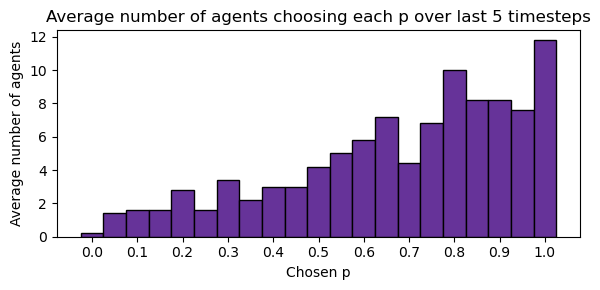

In [499]:
# actions_p: matrix of chosen p-levels, shape (T, N)
actions_p = res["chosen_history"]   # or whichever array stores p-level choices

# Focus on last w timesteps
last_actions = actions_p[-w:, :]    # shape (w, N)

# Count how many agents chose each p-value at each timestep
# p-values correspond to discrete levels k/M for k in [0, M]
counts_per_timestep = np.zeros((w, M+1))

for t in range(w):
    unique, counts = np.unique(last_actions[t], return_counts=True)
    counts_per_timestep[t, unique] = counts

# Compute average number of agents choosing each p-level across the last w steps
avg_counts = counts_per_timestep.mean(axis=0)

# Create x-axis values (the actual p-levels)
p_levels = np.arange(M+1) / M

# ---- Plot ----
plt.figure(figsize=(6, 3))
plt.bar(p_levels, avg_counts, edgecolor='black', color='rebeccapurple', width=1.0/M * 1.0)

plt.title(f"Average number of agents choosing each p over last {w} timesteps")
plt.xlabel("Chosen p")
plt.ylabel("Average number of agents")
plt.xticks(np.linspace(0, 1, 11))

plt.tight_layout()
plt.show()


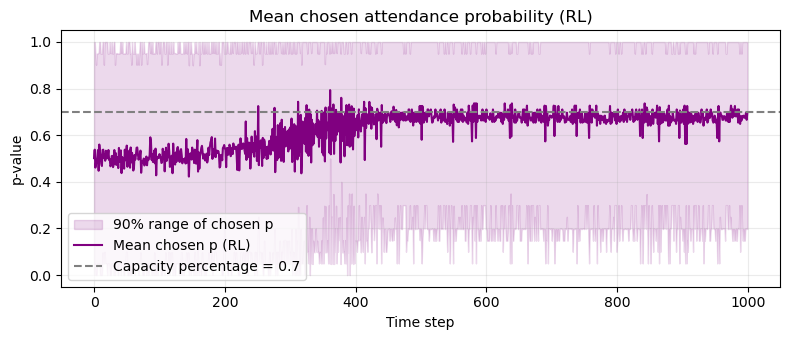

In [468]:

p_values_TM = res["chosen_history"] / M  # shape (T, N)


# Compute 5th and 95th percentiles across agents
p05 = np.percentile(p_values_TM, 5, axis=1)
p95 = np.percentile(p_values_TM, 95, axis=1)

plt.figure(figsize=(8, 3.5))

# 90% range shading
plt.fill_between(
    np.arange(len(mean_p)), 
    p05, p95, 
    color='purple', 
    alpha=0.15, 
    label='90% range of chosen p'
)

# Mean line
plt.plot(mean_p, label='Mean chosen p (RL)', color='purple')

# Capacity threshold
plt.axhline(C_frac, color='gray', linestyle='--', label=f'Capacity percentage = {C_frac}')

plt.title("Mean chosen attendance probability (RL)")
plt.xlabel("Time step")
plt.ylabel("p-value")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


# Payoff

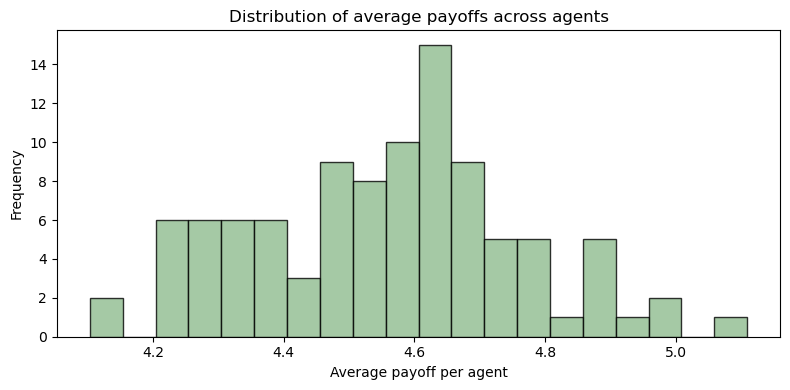

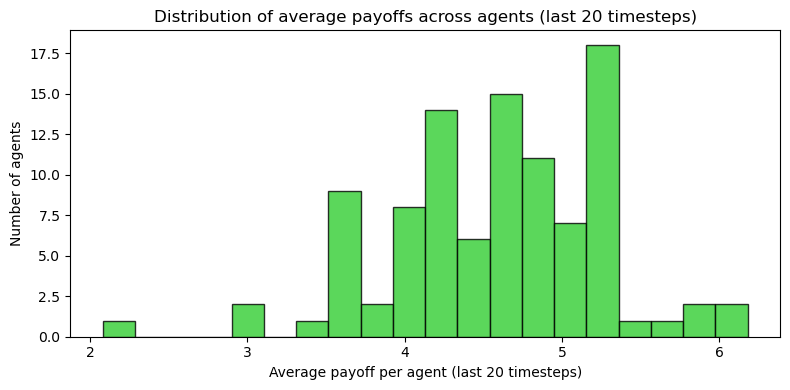

In [469]:
# Compute each agent’s average payoff over the full run
agent_avg_payoffs = res["all_payoffs"].mean(axis=0)

plt.figure(figsize=(8, 4))
plt.hist(agent_avg_payoffs, bins=20, color="darkseagreen", edgecolor="black", alpha=0.8)
plt.xlabel("Average payoff per agent")
plt.ylabel("Frequency")
plt.title("Distribution of average payoffs across agents")
plt.tight_layout()
plt.show()


# --- Compute average payoff across the last 10 timesteps for each agent ---
last_window = 20  # number of final timesteps to average
last_10_avg_payoffs = res["all_payoffs"][-last_window:, :].mean(axis=0)

# --- Plot: Histogram of average payoffs across agents (last 10 timesteps) ---
plt.figure(figsize=(8, 4))
plt.hist(last_10_avg_payoffs, bins=20, color="limegreen", edgecolor="black", alpha=0.8)
plt.xlabel("Average payoff per agent (last 20 timesteps)")
plt.ylabel("Number of agents")
plt.title("Distribution of average payoffs across agents (last 20 timesteps)")
plt.tight_layout()
plt.show()

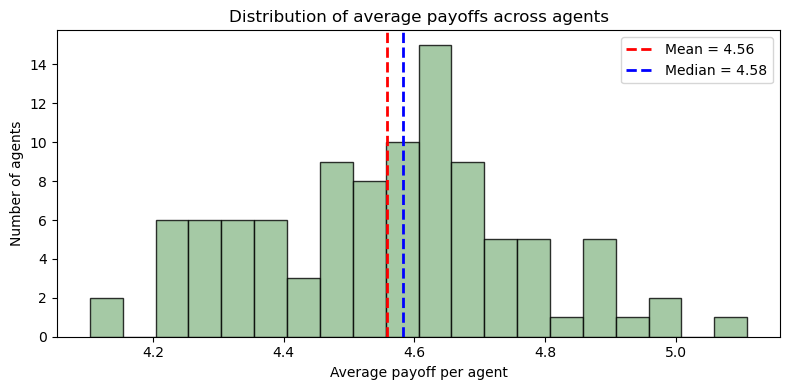

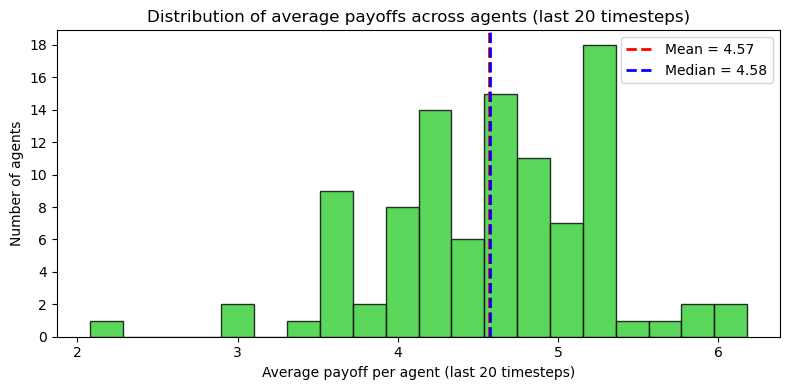

In [496]:
# Compute each agent’s average payoff over the full run
agent_avg_payoffs = res["all_payoffs"].mean(axis=0)

mean_val = agent_avg_payoffs.mean()
median_val = np.median(agent_avg_payoffs)



plt.figure(figsize=(8, 4))
plt.hist(agent_avg_payoffs, bins=20, color="darkseagreen", edgecolor="black", alpha=0.8)

# --- Add mean and median lines ---
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color="blue", linestyle="--", linewidth=2, label=f"Median = {median_val:.2f}")

plt.xlabel("Average payoff per agent")
plt.ylabel("Number of agents")
plt.title("Distribution of average payoffs across agents")
plt.legend()
plt.tight_layout()
plt.show()

# --- Compute average payoff across the last 20 timesteps for each agent ---
last_window = 20
last_20_avg_payoffs = res["all_payoffs"][-last_window:, :].mean(axis=0)

mean_val_last = last_20_avg_payoffs.mean()
median_val_last = np.median(last_20_avg_payoffs)

plt.figure(figsize=(8, 4))
plt.hist(last_20_avg_payoffs, bins=20, color="limegreen", edgecolor="black", alpha=0.8)

# --- Add mean and median lines ---
plt.axvline(mean_val_last, color="red", linestyle="--", linewidth=2,
            label=f"Mean = {mean_val_last:.2f}")
plt.axvline(median_val_last, color="blue", linestyle="--", linewidth=2,
            label=f"Median = {median_val_last:.2f}")

plt.xlabel("Average payoff per agent (last 20 timesteps)")
plt.ylabel("Number of agents")
plt.title("Distribution of average payoffs across agents (last 20 timesteps)")
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.legend()
plt.tight_layout()
plt.show()


# Non-attendance streaks

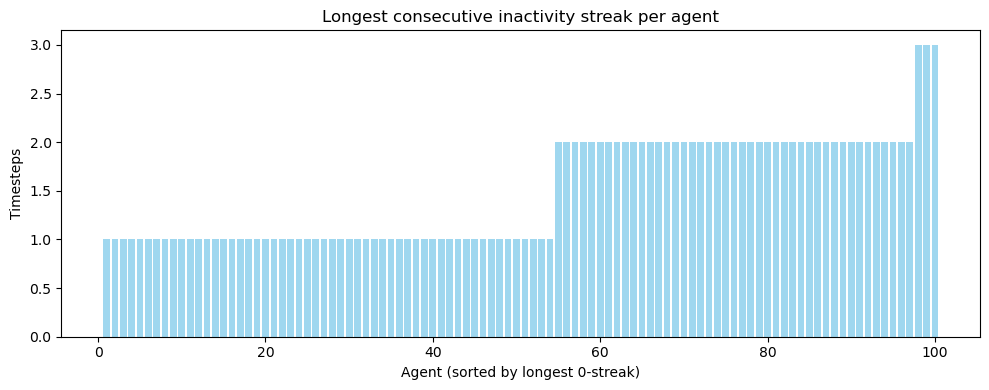

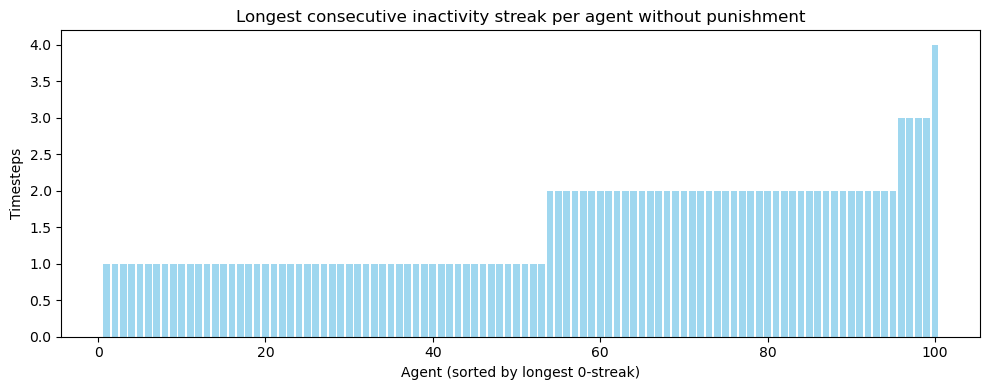

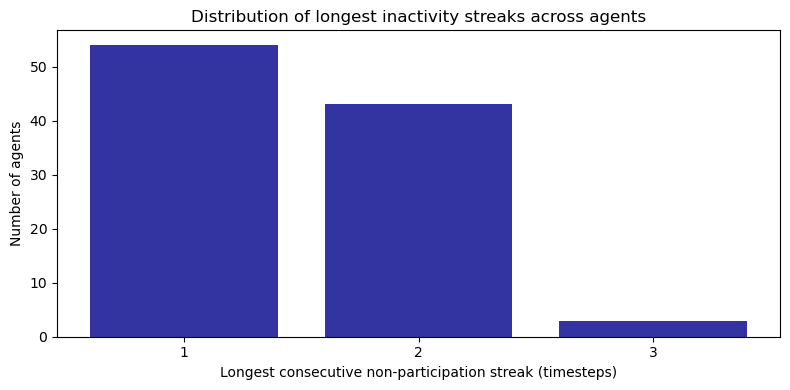

In [472]:
res_nopun = run_discrete_prob_rl(G=G, S=S, F=F, N=N, C=C, T=1000, M=M, lr=LR, gamma=GAMMA, 
                               tau_start=TAU_START, tau_min=TAU_MIN,
                         rho=rho, alpha=alpha, beta=0, bar_theta=bar_theta,
                         theta_cap=theta_cap, k_init=K_INIT, SEED=SEED)

actions_nopun = res_nopun["chosen_history"]
actions = res["chosen_history"]  # shape (T, N) - try with chosen action counts it give fun results 
N = actions.shape[1]

longest_zero_streaks = np.zeros(N, dtype=int)

for i in range(N):
    longest = current = 0
    for a in actions[:, i]:
        if a == 0:
            current += 1
            longest = max(longest, current)
        else:
            current = 0
    longest_zero_streaks[i] = longest


longest_zero_streaks_nopun = np.zeros(N, dtype=int)

for i in range(N):
    longest = current = 0
    for a in actions_nopun[:, i]:
        if a == 0:
            current += 1
            longest = max(longest, current)
        else:
            current = 0
    longest_zero_streaks_nopun[i] = longest


# --- Sorted bar plot ---
plt.figure(figsize=(10, 4))
plt.bar(np.arange(N)+1, np.sort(longest_zero_streaks), color="skyblue", alpha=0.8)
plt.xlabel("Agent (sorted by longest 0-streak)")
plt.ylabel("Timesteps")
plt.title("Longest consecutive inactivity streak per agent")
plt.tight_layout()
plt.show()  

# --- Sorted bar plot ---
plt.figure(figsize=(10, 4))
plt.bar(np.arange(N)+1, np.sort(longest_zero_streaks_nopun), color="skyblue", alpha=0.8)
plt.xlabel("Agent (sorted by longest 0-streak)")
plt.ylabel("Timesteps")
plt.title("Longest consecutive inactivity streak per agent without punishment")
plt.tight_layout()
plt.show()  


# Convert streak lengths into a bar plot
unique_streaks, counts = np.unique(longest_zero_streaks, return_counts=True)

plt.figure(figsize=(8, 4))
plt.bar(unique_streaks, counts, color="darkblue", alpha=0.8)

plt.xlabel("Longest consecutive non-participation streak (timesteps)")
plt.ylabel("Number of agents")
plt.title("Distribution of longest inactivity streaks across agents")

plt.xticks(unique_streaks)  # show every streak value
plt.tight_layout()
plt.show()






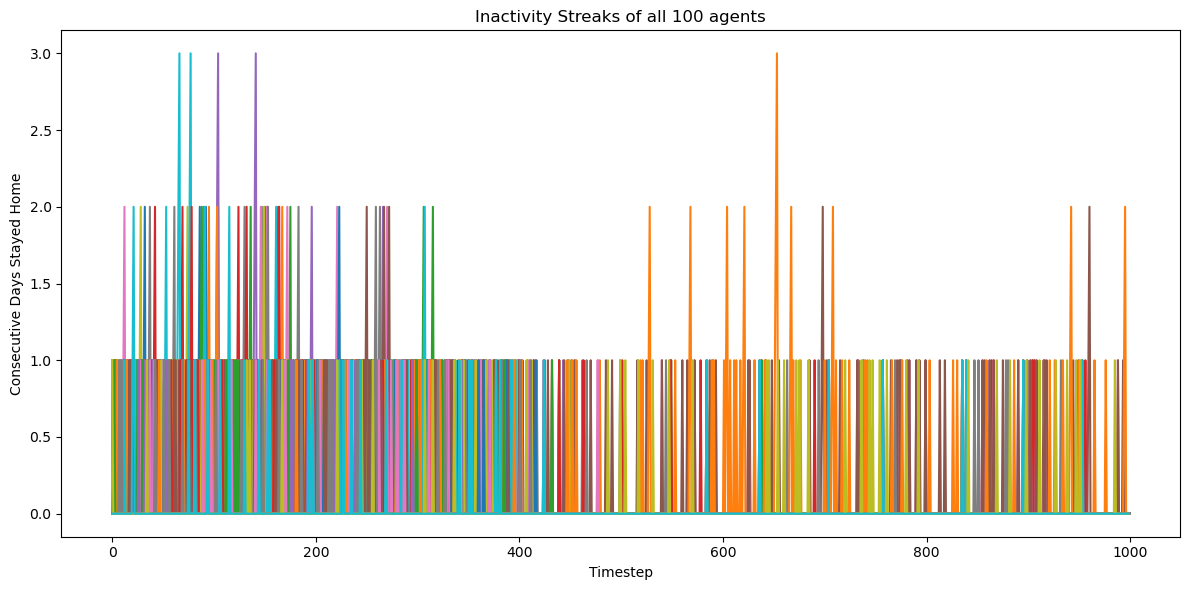

In [ ]:
def plot_inactivity_streaks(chosen_history, n_agents=3, seed=404):
    """
    Plots inactivity streaks (consecutive days of staying home)
    for n randomly chosen agents.
    
    Parameters:
    - actions_history: array of shape (T, N), entries in {0,1}
    - n_agents: number of agents to plot streaks for
    - seed: random seed for agent selection
    """
    T, N = chosen_history.shape
    
    # Choose random agents
    chosen_agents = np.random.choice(N, size=n_agents, replace=False)
    
    # Compute streaks
    streaks = np.zeros((T, n_agents), dtype=int)

    for idx, agent in enumerate(chosen_agents):
        streak = 0
        for t in range(T):
            if chosen_history[t, agent] == 0:
                streak += 1
            else:
                streak = 0
            streaks[t, idx] = streak

    # Plot
    plt.figure(figsize=(12, 6))
    for i in range(n_agents):
        plt.plot(streaks[:, i], label=f"Agent {chosen_agents[i]}")

    plt.xlabel("Timestep")
    plt.ylabel("Consecutive Days Stayed Home")
    plt.title(f"Inactivity Streaks of all {n_agents} agents")
    #plt.legend()
    plt.tight_layout()
    plt.show()


plot_inactivity_streaks(res["chosen_history"], n_agents=100)


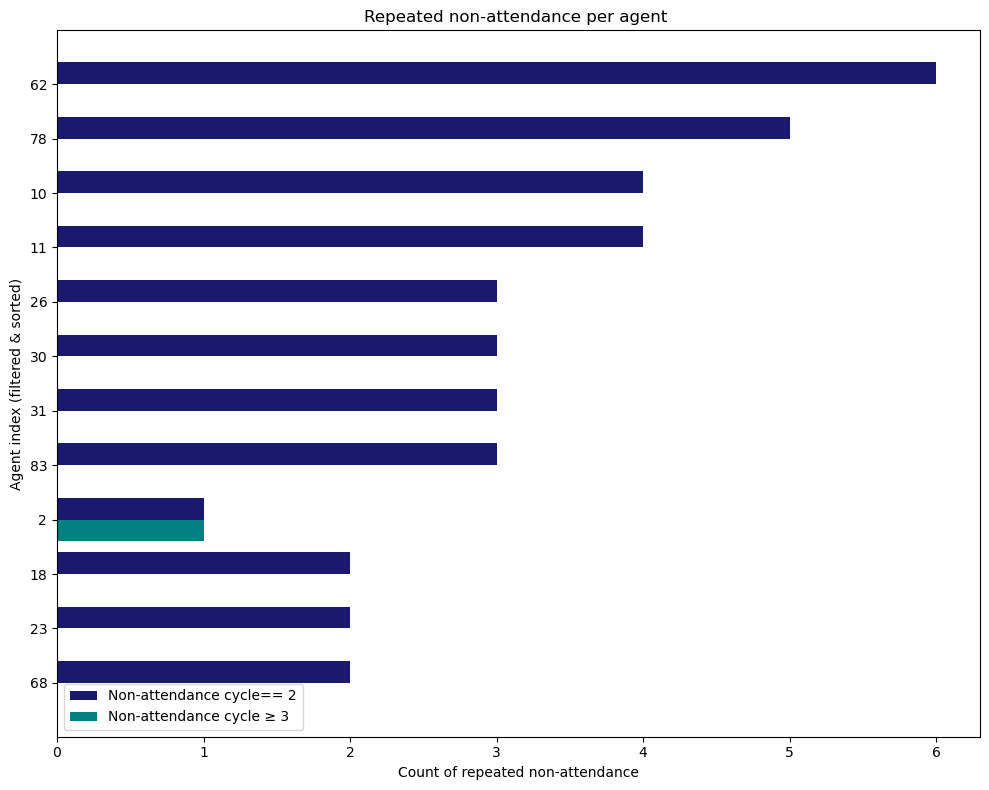

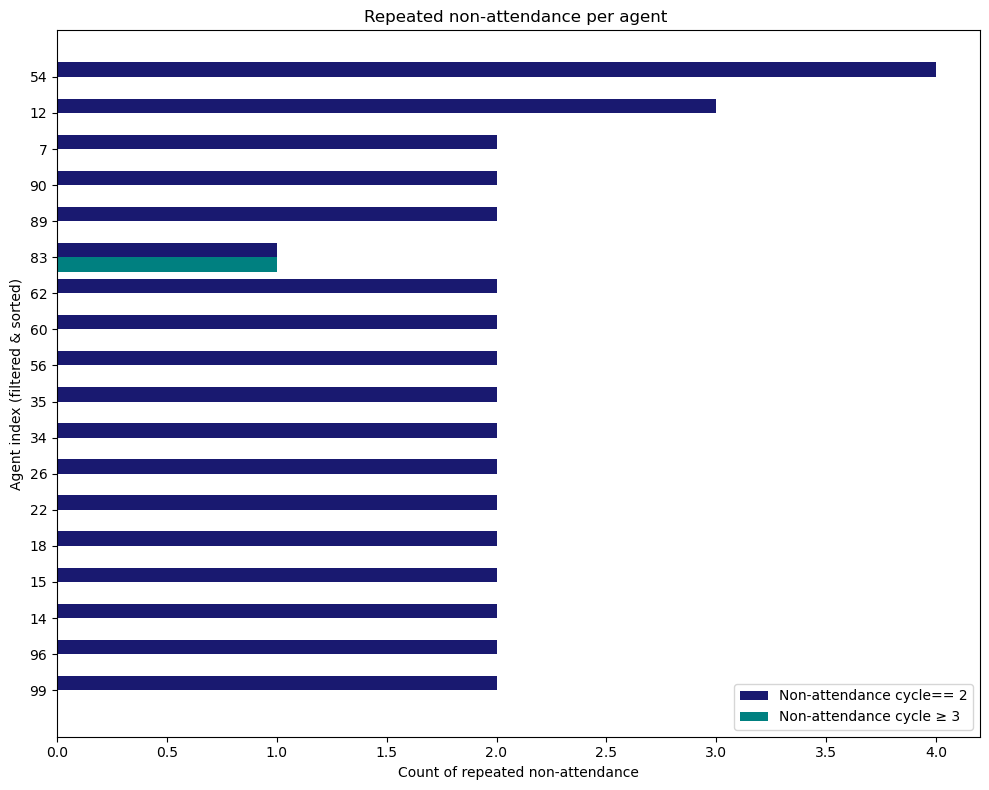

In [ ]:
res_nopun = run_discrete_prob_rl(G=8, S=S, F=F, N=N, C=C, T=1000, M=M, lr=LR, gamma=GAMMA, 
                               tau_start=TAU_START, tau_min=TAU_MIN,
                         rho=rho, alpha=alpha, beta=0, bar_theta=bar_theta,
                         theta_cap=theta_cap, k_init=K_INIT, SEED=SEED)

res = run_discrete_prob_rl(G=8, S=S, F=F, N=N, C=C, T=1000, M=M, lr=LR, gamma=GAMMA, 
                               tau_start=TAU_START, tau_min=TAU_MIN,
                         rho=rho, alpha=alpha, beta=1.0, bar_theta=bar_theta,
                         theta_cap=theta_cap, k_init=K_INIT, SEED=SEED)
    



def plot_repeated_nonattendance_with_force(actions_history,
                                           force_include=None,
                                           overlap=False,
                                           figsize=(10, 8),
                                           colors=("midnightblue", "teal")):
    arr = np.asarray(actions_history)
    if arr.ndim != 2:
        raise ValueError("actions_history must be a 2D array of shape (T, N).")
    T, N = arr.shape

    if force_include is None:
        force_include = []
    else:
        # sanitize indices and keep only valid ints
        force_include = [int(i) for i in force_include if (0 <= int(i) < N)]

    runs_eq2 = np.zeros(N, dtype=int)
    runs_ge3 = np.zeros(N, dtype=int)

    for i in range(N):
        seq = arr[:, i]

        # Non-overlapping run-length encoding
        runs = []
        cnt = 0
        for v in seq:
            if v == 0:
                cnt += 1
            else:
                if cnt > 0:
                    runs.append(cnt)
                    cnt = 0
        if cnt > 0:
            runs.append(cnt)
        runs = np.array(runs, dtype=int) if len(runs) else np.array([], dtype=int)

        if not overlap:
            runs_eq2[i] = int(np.sum(runs == 2))
            runs_ge3[i] = int(np.sum(runs >= 3))
        else:
            # overlapping pairs for runs==2
            runs_eq2[i] = int(np.sum((seq[:-1] == 0) & (seq[1:] == 0)))
            runs_ge3[i] = int(np.sum(runs >= 3))

    total_repeated_runs = runs_eq2 + runs_ge3

    # Main inclusion mask: total >= 2 OR forced-in agents
    mask_main = total_repeated_runs >= 2
    mask_force = np.zeros(N, dtype=bool)
    if len(force_include) > 0:
        mask_force[force_include] = True

    mask = mask_main | mask_force

    #if mask.sum() == 0:
        #print("No agents meet the display criteria")
        #return

    # Extract and sort agents by total repeated runs (descending).
    agent_idx_all = np.arange(N)[mask]
    totals_filtered = total_repeated_runs[mask]
    order_local = np.argsort(-totals_filtered)  # descending

    agent_idx = agent_idx_all[order_local]
    runs_eq2_s = runs_eq2[agent_idx]
    runs_ge3_s = runs_ge3[agent_idx]

    # Plotting (grouped horizontal bars)
    y = np.arange(len(agent_idx))
    bar_w = 0.4

    plt.figure(figsize=figsize)
    plt.barh(y - bar_w/2, runs_eq2_s, height=bar_w, color=colors[0], label='Non-attendance cycle== 2')
    plt.barh(y + bar_w/2, runs_ge3_s, height=bar_w, color=colors[1], label='Non-attendance cycle ≥ 3')

    plt.yticks(y, agent_idx)
    plt.gca().invert_yaxis()

    plt.xlabel("Count of repeated non-attendance")
    plt.ylabel("Agent index (filtered & sorted)")
    plt.title("Repeated non-attendance per agent ")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_repeated_nonattendance_with_force(res_nopun["chosen_history"])
plot_repeated_nonattendance_with_force(res["chosen_history"])




# Parameter compareson and the impact of different values

In [518]:
def compare_parameter(param_name, values, plot_func, base_kwargs, ncols=3):
    """
    Generate subplots comparing simulation results across parameter values.

    Args:
        param_name: str, name of parameter to vary (e.g. 'rho')
        values: list of parameter values to test
        plot_func: function that takes (res, ax, label) and plots on the given axis
        base_kwargs: default kwargs for run_discrete_prob_rl
        ncols: number of columns in subplot grid
    """
    n = len(values)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3.5 * nrows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, val in enumerate(values):
        kwargs = base_kwargs.copy()
        kwargs[param_name] = val
        print(f"Running {param_name}={val:.3f}")
        res = run_discrete_prob_rl(**kwargs)

        plot_func(res, axes[i], f"{param_name}={val:.3f}")

    # Clean up unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_avg_payoff(res, ax, label):
    """
    Plot a histogram of average per-agent payoffs for a given RL run.
    """

    
    # Compute average payoff per agent across all timesteps
    agent_avg_payoffs = res["all_payoffs"].mean(axis=0)

    mean = agent_avg_payoffs.mean()

    # Histogram (same style as the standalone version)
    ax.axvline(mean, color="red", linestyle="--", linewidth=2,
            label=f"Mean = {mean_val_last:.2f}")
    ax.hist(agent_avg_payoffs, bins=20, color="darkseagreen",
            edgecolor="black", alpha=0.8)

    ax.set_title(f"{label} — Avg Payoff Distribution")
    ax.set_xlabel("Average payoff per agent")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.25)
    print(mean)


def plot_attendance(res, ax, label):
    ax.plot(res["attendance_ts"], color="tab:blue", lw=2, label=label)
    ax.set_title(label)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Attendance")

def plot_mean_p(res, ax, label):
    mean_p = res["mean_p_ts"]
    ax.plot(mean_p, color="tab:purple", lw=2)
    ax.set_title(label)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Mean p")


param_values_beta = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5] # above 1,875 should destroy learning

base_kwargs = dict(
    G=G, S=S, F=F, N=N, C=C, T=500, M=M, lr=LR, gamma=GAMMA,
    tau_start=TAU_START, tau_min=TAU_MIN,
    rho=rho, alpha=alpha, beta=0.5,
    bar_theta=bar_theta, theta_cap=theta_cap,
    k_init=K_INIT
)

#compare_parameter("beta", param_values_beta, plot_avg_payoff, base_kwargs, ncols=3)
#compare_parameter("beta", param_values_beta, plot_attendance, base_kwargs, ncols=3)
#compare_parameter("beta", param_values_beta, plot_mean_p, base_kwargs, ncols=3)



* Theta

Running bar_theta=0.000
4.963819999999999
Running bar_theta=0.500
4.943655988111766
Running bar_theta=1.000
4.6515951334622265
Running bar_theta=2.000
4.474118905316249


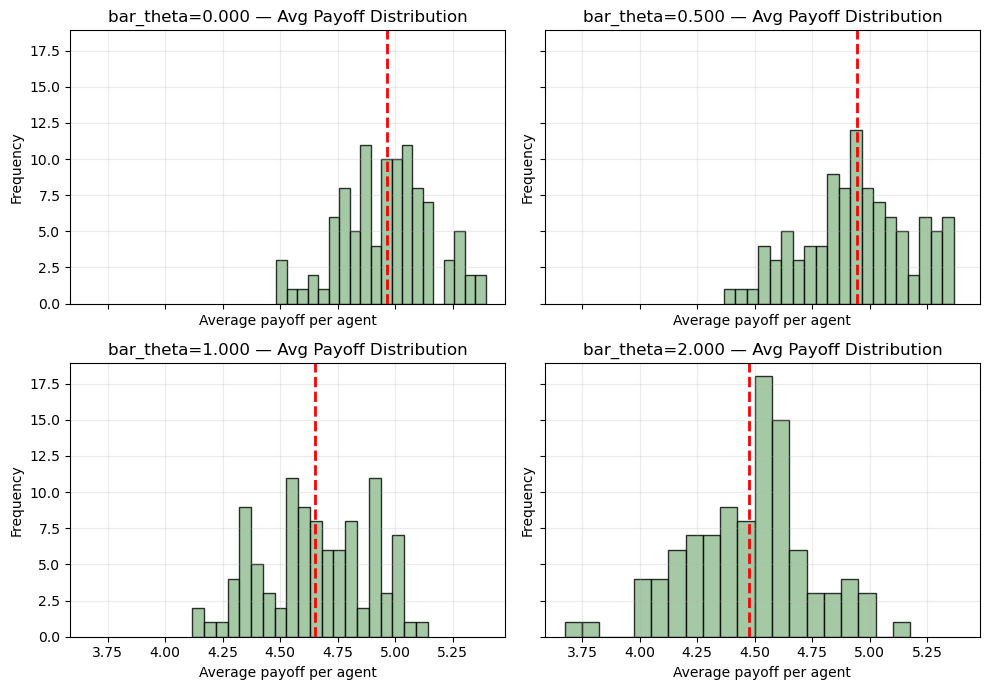

Running bar_theta=0.000
Running bar_theta=0.500
Running bar_theta=1.000
Running bar_theta=2.000


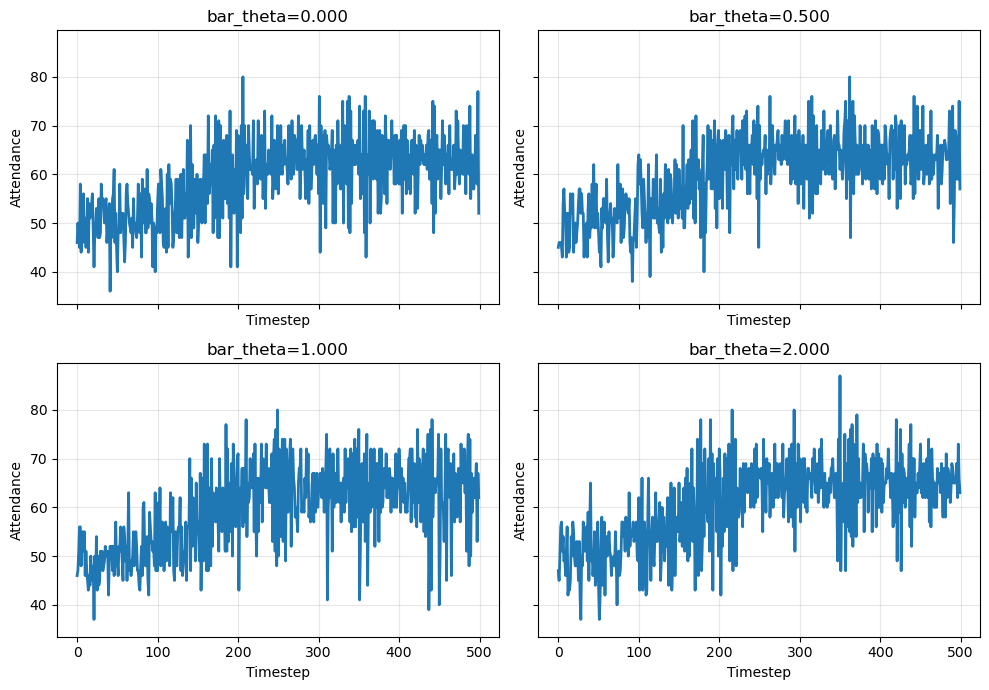

Running bar_theta=0.000
Running bar_theta=0.500
Running bar_theta=1.000
Running bar_theta=2.000


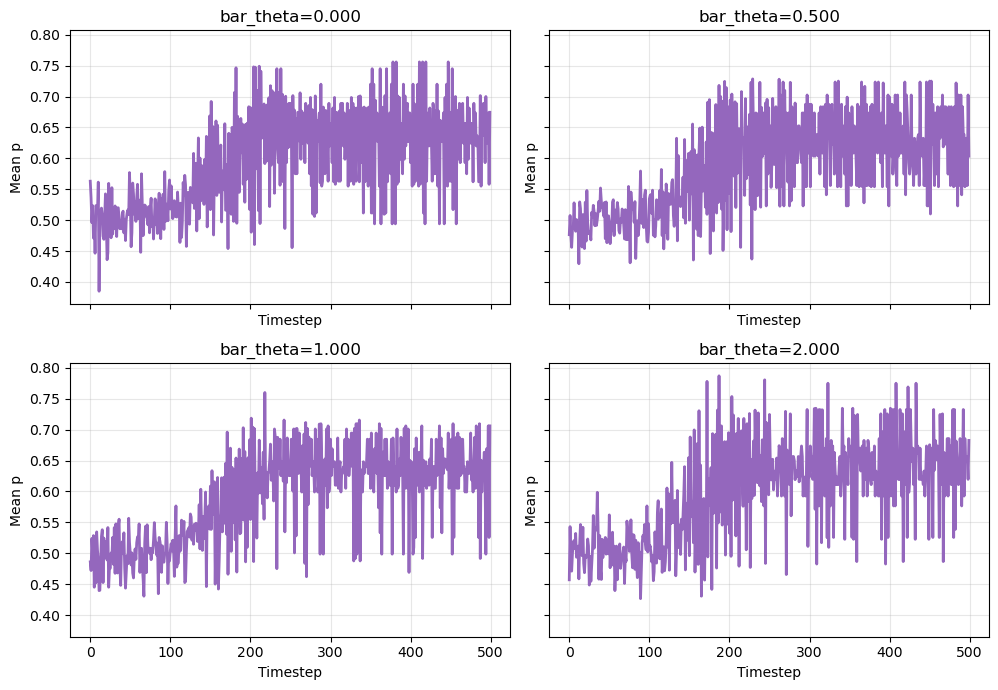

In [ ]:
param_values_theta = [ 0.0, 0.5, 1.0, 2.0]

base_kwargs = dict(
    G=G, S=S, F=F, N=N, C=C, T=500, M=M, lr=LR, gamma=GAMMA,
    tau_start=TAU_START, tau_min=TAU_MIN,
    rho=rho, alpha=alpha, beta=beta,
    bar_theta=0.8, theta_cap=theta_cap,
    k_init=K_INIT
)

compare_parameter("bar_theta", param_values_theta, plot_avg_payoff, base_kwargs, ncols=2)
compare_parameter("bar_theta", param_values_theta, plot_attendance, base_kwargs, ncols=2)
compare_parameter("bar_theta", param_values_theta, plot_mean_p, base_kwargs, ncols=2)

base_kwargs_M2 = dict(
    G=G, S=S, F=F, N=N, C=C, T=500, M=2, lr=LR, gamma=GAMMA,
    tau_start=TAU_START, tau_min=TAU_MIN,
    rho=rho, alpha=alpha, beta=beta,
    bar_theta=0.8, theta_cap=theta_cap,
    k_init=K_INIT
)

#compare_parameter("bar_theta", param_values_theta, plot_mean_p, base_kwargs_M2, ncols=3)


* Learning rate

Running lr=0.001
Running lr=0.010
Running lr=0.100
Running lr=0.200
Running lr=0.300
Running lr=0.500


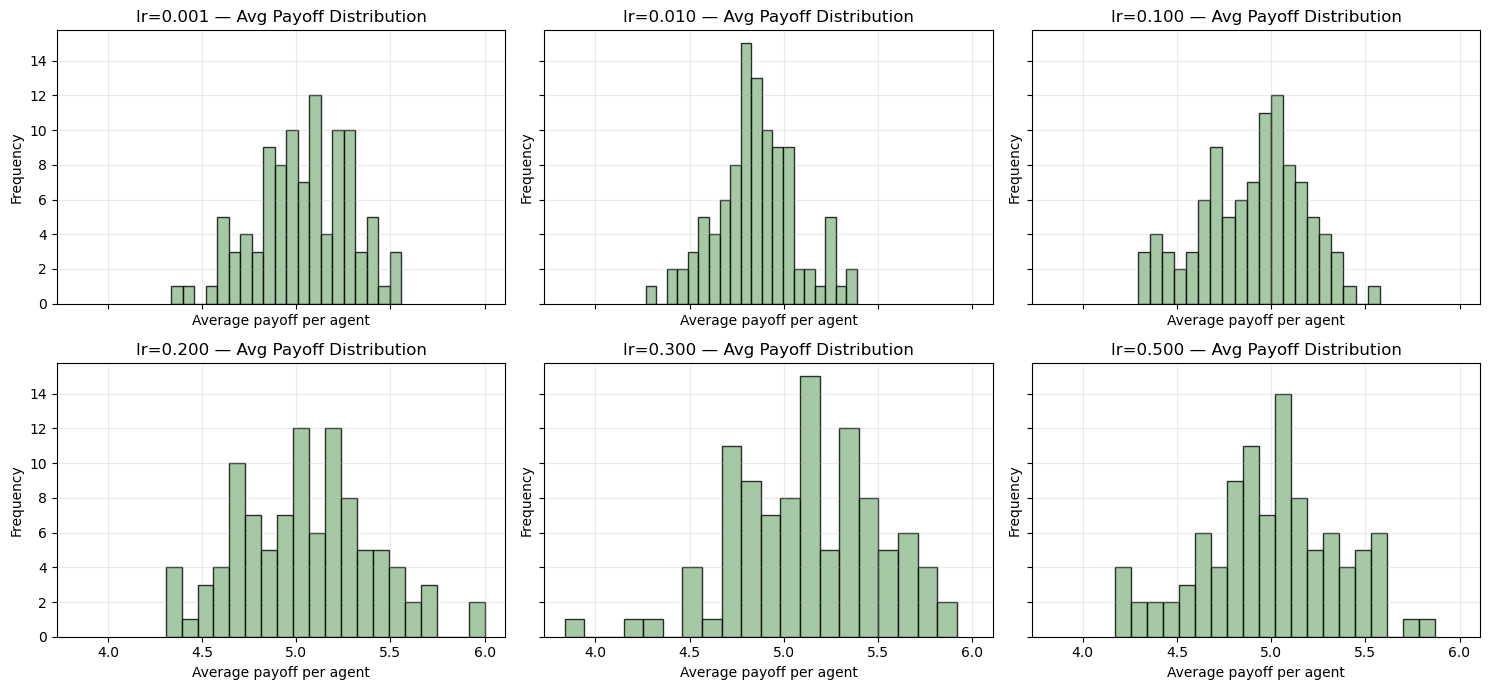

Running lr=0.001
Running lr=0.010
Running lr=0.100
Running lr=0.200
Running lr=0.300
Running lr=0.500


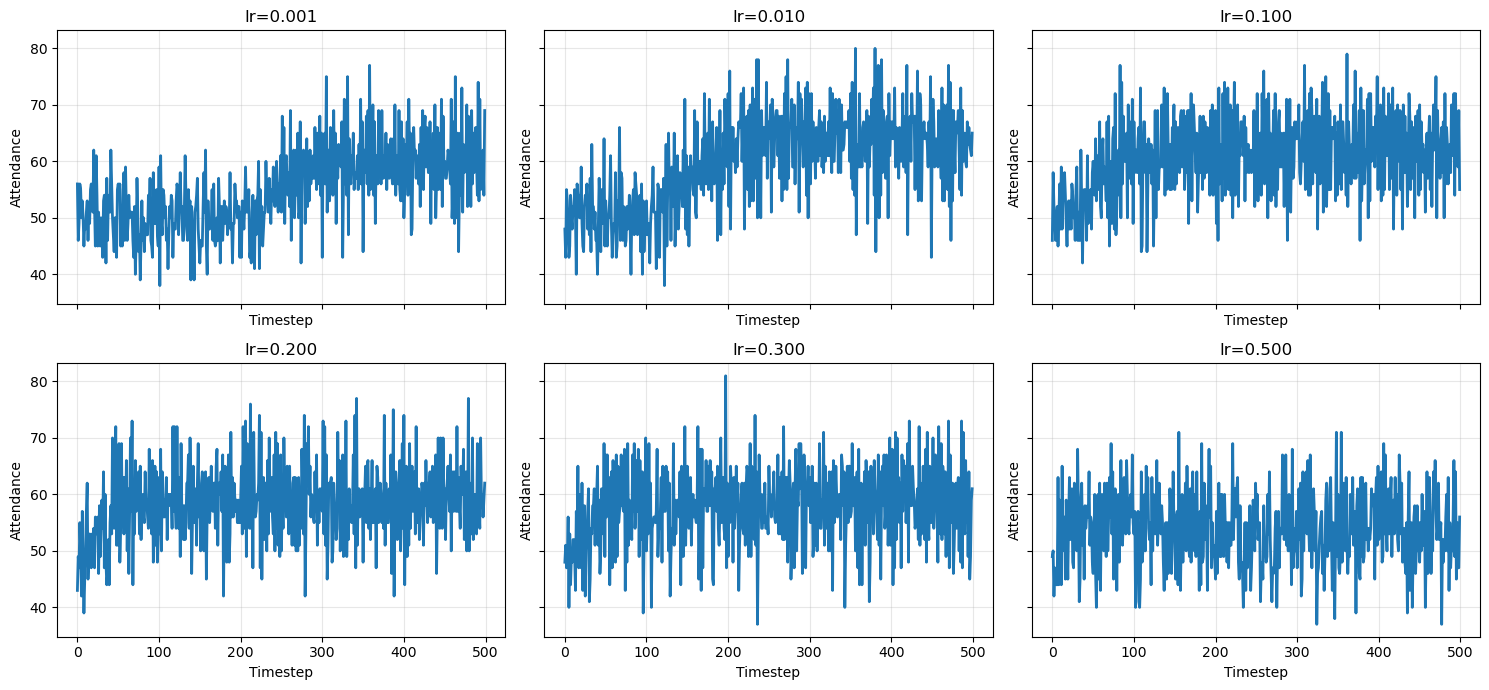

Running lr=0.001
Running lr=0.010
Running lr=0.100
Running lr=0.200
Running lr=0.300
Running lr=0.500


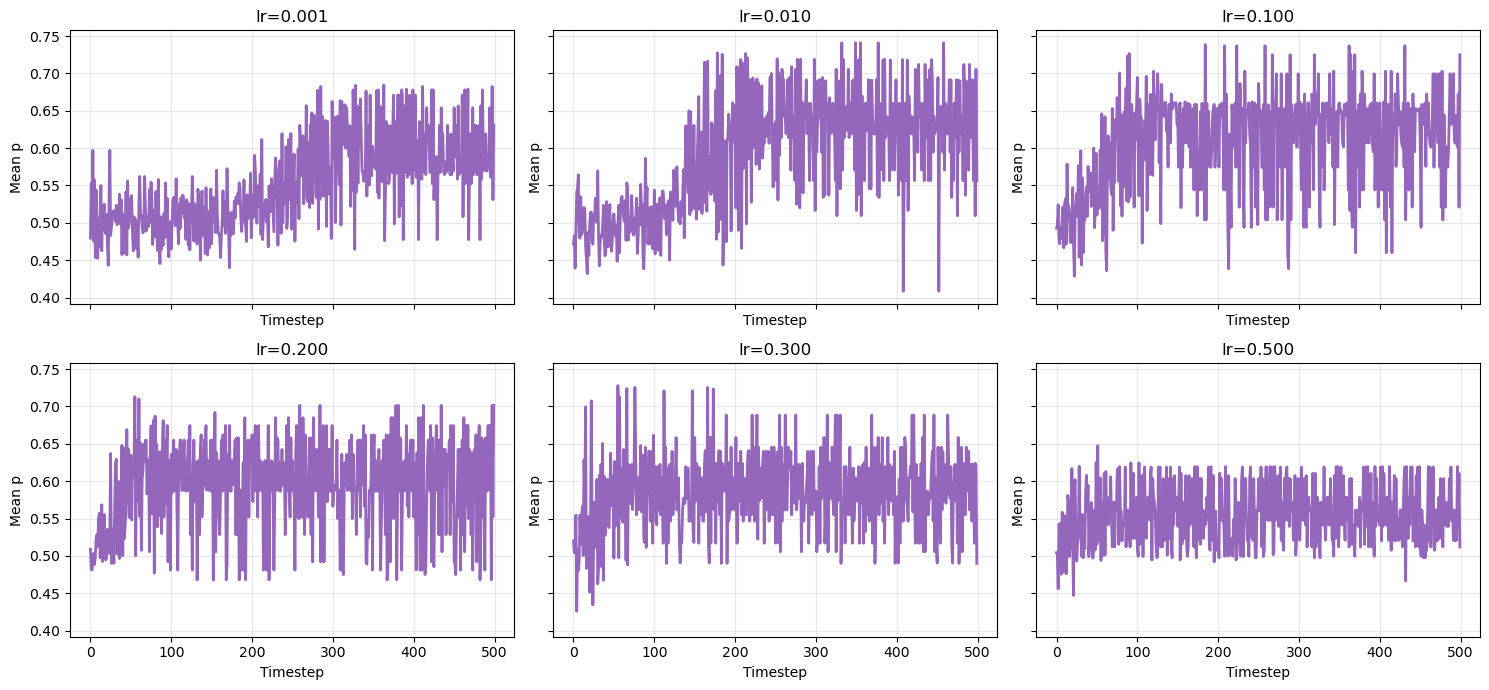

In [ ]:
param_values_LR = [ 0.001, 0.01, 0.1, 0.2, 0.3, 0.5]

base_kwargs = dict(
    G=G, S=S, F=F, N=N, C=C, T=500, M=M, lr=0.01, gamma=GAMMA,
    tau_start=TAU_START, tau_min=TAU_MIN,
    rho=rho, alpha=alpha, beta=beta,
    bar_theta=bar_theta, theta_cap=theta_cap,
    k_init=K_INIT
)

compare_parameter("lr", param_values_LR, plot_avg_payoff, base_kwargs, ncols=3)
compare_parameter("lr", param_values_LR, plot_attendance, base_kwargs, ncols=3)
compare_parameter("lr", param_values_LR, plot_mean_p, base_kwargs, ncols=3)


* Discount factor

Running gamma=0.100
Running gamma=0.300
Running gamma=0.500
Running gamma=0.700
Running gamma=0.900
Running gamma=1.000


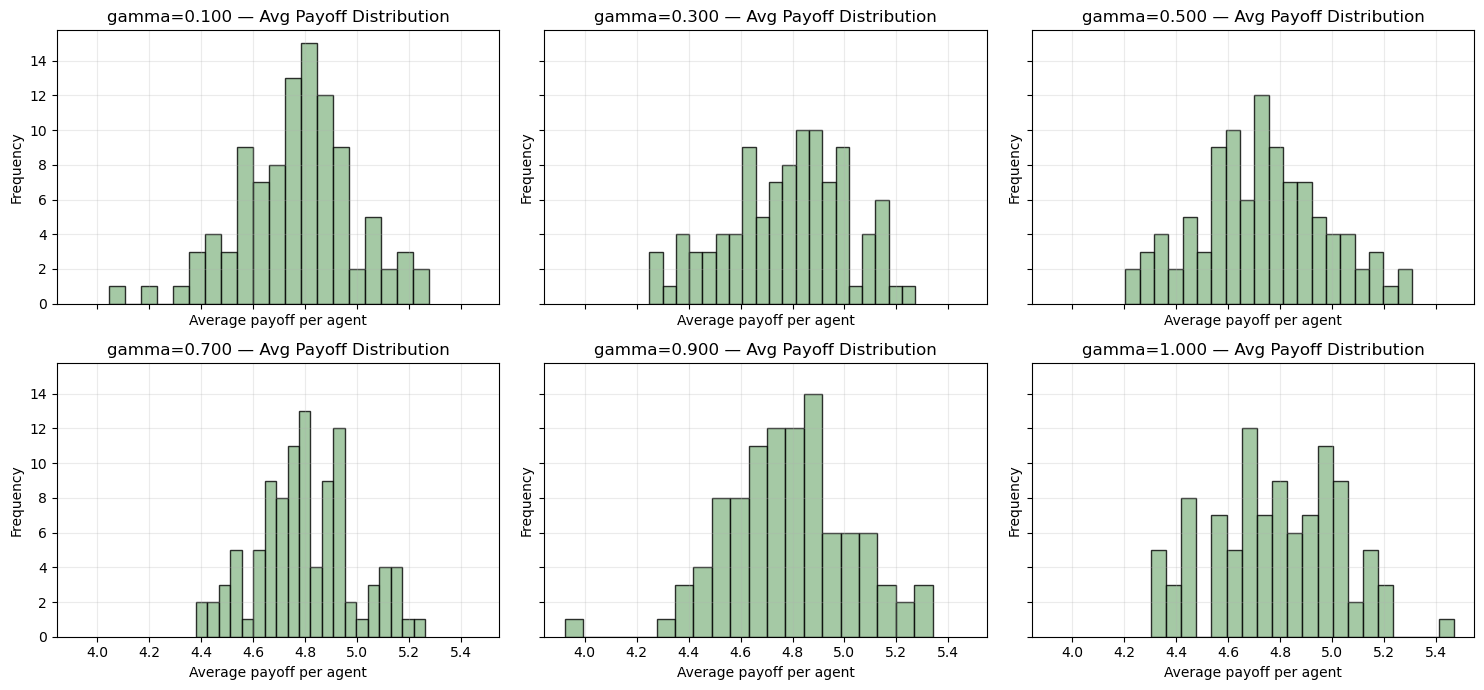

Running gamma=0.100
Running gamma=0.300
Running gamma=0.500
Running gamma=0.700
Running gamma=0.900
Running gamma=1.000


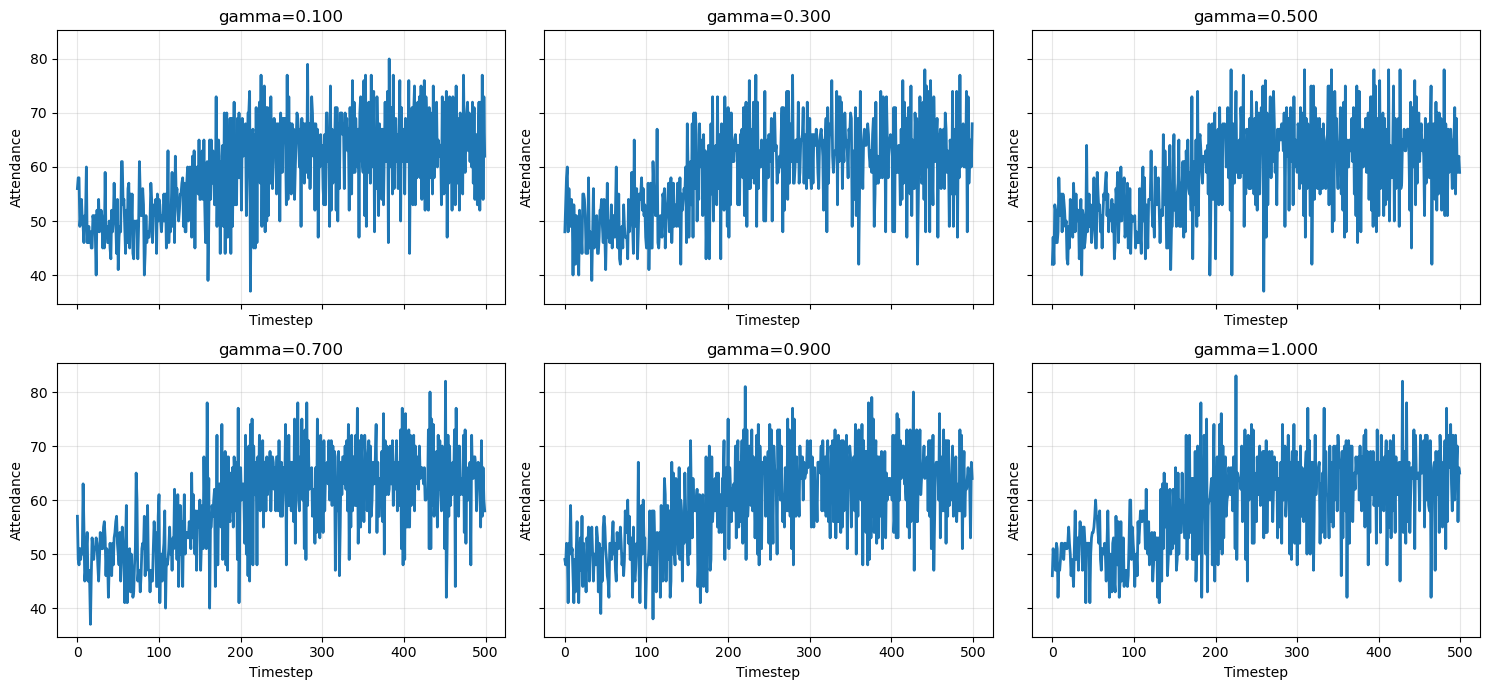

Running gamma=0.100
Running gamma=0.300
Running gamma=0.500
Running gamma=0.700
Running gamma=0.900
Running gamma=1.000


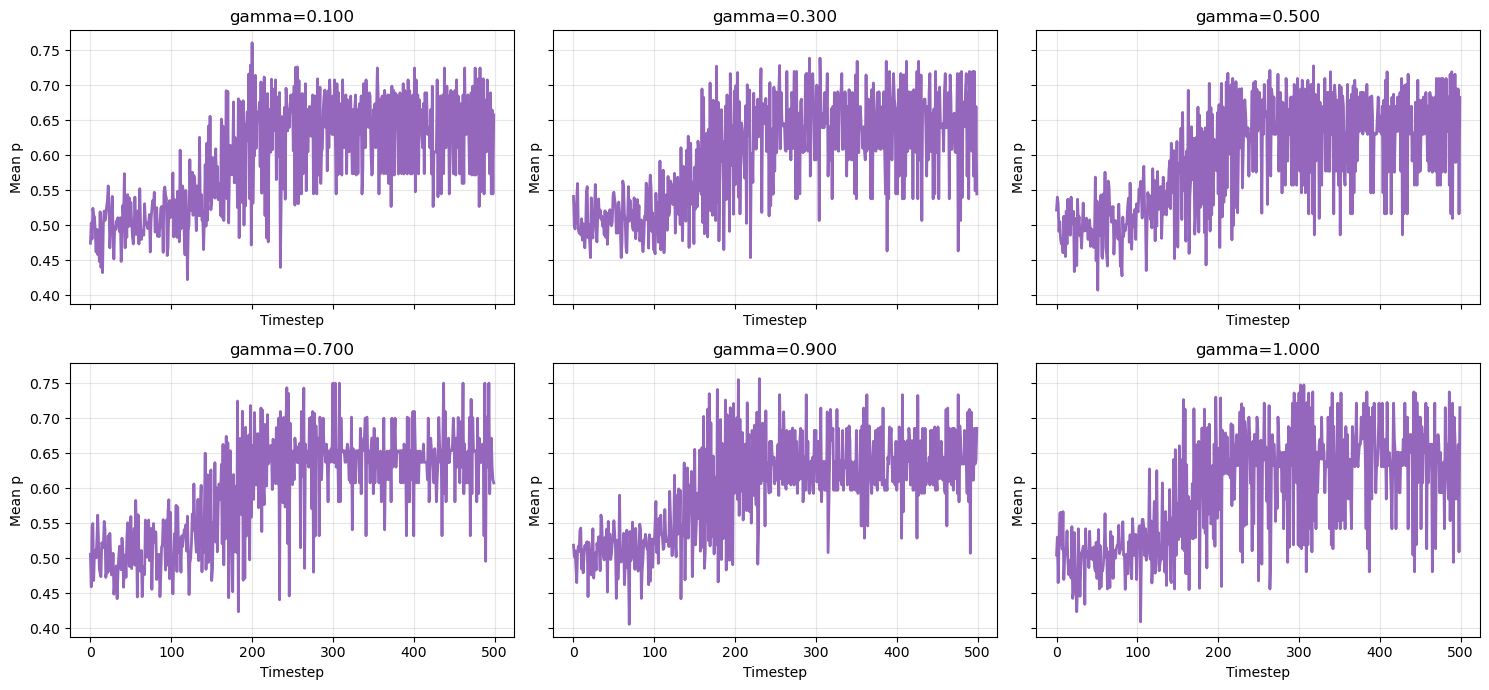

In [ ]:
param_values_gamma = [ 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

base_kwargs = dict(
    G=G, S=S, F=F, N=N, C=C, T=500, M=M, lr=LR, gamma=0.7,
    tau_start=TAU_START, tau_min=TAU_MIN,
    rho=rho, alpha=alpha, beta=beta,
    bar_theta=bar_theta, theta_cap=theta_cap,
    k_init=K_INIT
)

compare_parameter("gamma", param_values_gamma, plot_avg_payoff, base_kwargs, ncols=3)
compare_parameter("gamma", param_values_gamma, plot_attendance, base_kwargs, ncols=3)
compare_parameter("gamma", param_values_gamma, plot_mean_p, base_kwargs, ncols=3)

* Action space size parameter

Running M=2.000
Running M=5.000
Running M=10.000
Running M=20.000
Running M=50.000
Running M=100.000


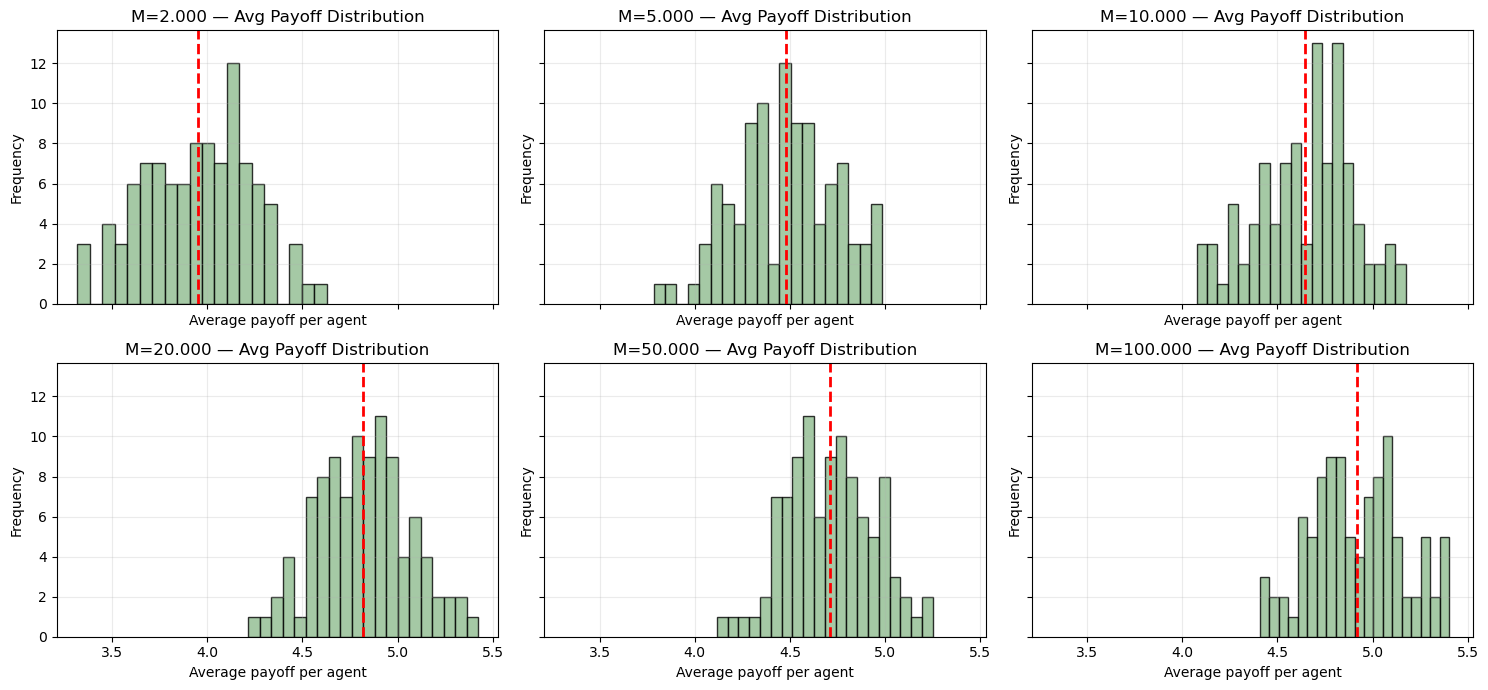

In [512]:
param_values_M = [ 2, 5, 10, 20, 50, 100]

base_kwargs = dict(
    G=G, S=S, F=F, N=N, C=C, T=500, M=20, lr=LR, gamma=GAMMA,
    tau_start=TAU_START, tau_min=TAU_MIN,
    rho=rho, alpha=alpha, beta=beta,
    bar_theta=bar_theta, theta_cap=theta_cap,
    k_init=K_INIT
)

compare_parameter("M", param_values_M, plot_avg_payoff, base_kwargs, ncols=3)
#compare_parameter("M", param_values_M, plot_attendance, base_kwargs, ncols=3)
#compare_parameter("M", param_values_M, plot_mean_p, base_kwargs, ncols=3)

# The impact of G, S and F (in heatmaps)

In [ ]:
def sweep_2d(param_x, values_x, param_y, values_y, summary_func, **base_kwargs):

    results = np.zeros((len(values_y), len(values_x)))
    for j, yval in enumerate(values_y):
        for i, xval in enumerate(values_x):
            kwargs = base_kwargs.copy()
            kwargs[param_x] = xval
            kwargs[param_y] = yval
            print(f"Running {param_x}={xval:.3f}, {param_y}={yval:.3f}")
            res = run_discrete_prob_rl(**kwargs)
            results[j, i] = summary_func(res)
    return results

def avg_attendance(res):
    return np.mean(res["attendance_ts"][-200:])  # average attendance over last 200 steps

def avg_payoff(res):
    return np.mean(res["avg_payoff_ts"][-200:])  # mean payoff in steady state

def avg_inactivity(res):
    # fraction of time agents are inactive near the end
    actions = (res["chosen_history"] > 0).astype(int)
    inactive = 1 - actions.mean(axis=1)
    return np.mean(inactive[-200:])

G_values = np.linspace(6, 12, 5)
S_values = np.linspace(2, 5, 5)
F_values = np.linspace(-1.5, 1.5, 5)

heatmap_data_GS = sweep_2d("G", G_values, "S", S_values,
                        summary_func=avg_attendance, F=F,
                        N=N, C=C, T=500, M=M, lr=LR, gamma=GAMMA,
                        tau_start=TAU_START, tau_min=TAU_MIN, rho=rho,
                        alpha=alpha, beta=beta, bar_theta=bar_theta,
                        theta_cap=theta_cap, k_init=K_INIT)


plt.figure(figsize=(7, 5))
im = plt.imshow(heatmap_data_GS, origin='lower', aspect='auto',
                extent=[G_values[0], G_values[-1], S_values[0], S_values[-1]],
                cmap='viridis')
plt.colorbar(im, label="Average attendance (last 200 steps)")
plt.xlabel("G (payoff from uncrowded bar)")
plt.ylabel("S (payoff from staying home)")
plt.title("2D Parameter Sweep: Average Attendance")
plt.tight_layout()
plt.show()





Running G=6.000, S=2.000


KeyboardInterrupt: 

Running G=6.000, F=-1.500
Running G=7.500, F=-1.500
Running G=9.000, F=-1.500
Running G=10.500, F=-1.500
Running G=12.000, F=-1.500
Running G=6.000, F=-0.750
Running G=7.500, F=-0.750
Running G=9.000, F=-0.750
Running G=10.500, F=-0.750
Running G=12.000, F=-0.750
Running G=6.000, F=0.000
Running G=7.500, F=0.000
Running G=9.000, F=0.000
Running G=10.500, F=0.000
Running G=12.000, F=0.000
Running G=6.000, F=0.750
Running G=7.500, F=0.750
Running G=9.000, F=0.750
Running G=10.500, F=0.750
Running G=12.000, F=0.750
Running G=6.000, F=1.500
Running G=7.500, F=1.500
Running G=9.000, F=1.500
Running G=10.500, F=1.500
Running G=12.000, F=1.500


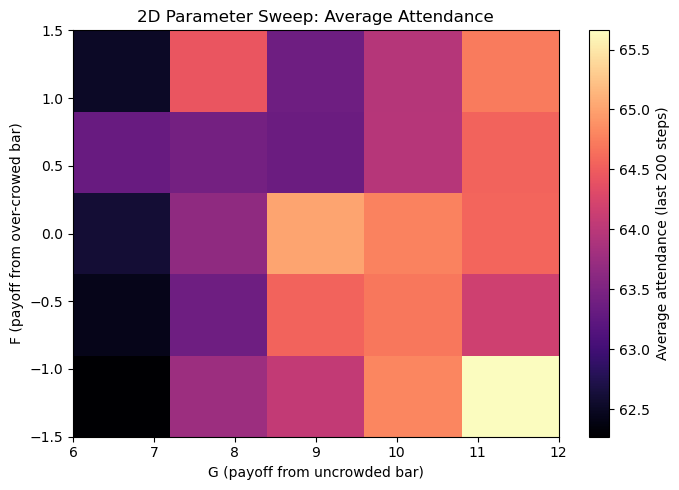

In [ ]:
heatmap_data_GF = sweep_2d("G", G_values, "F", F_values,
                        summary_func=avg_attendance, S=S,
                        N=N, C=C, T=500, M=M, lr=LR, gamma=GAMMA,
                        tau_start=TAU_START, tau_min=TAU_MIN, rho=rho,
                        alpha=alpha, beta=beta, bar_theta=bar_theta,
                        theta_cap=theta_cap, k_init=K_INIT)

plt.figure(figsize=(7, 5))
im = plt.imshow(heatmap_data_GF, origin='lower', aspect='auto',
                extent=[G_values[0], G_values[-1], F_values[0], F_values[-1]],
                cmap='magma')
plt.colorbar(im, label="Average attendance (last 200 steps)")
plt.xlabel("G (payoff from uncrowded bar)")
plt.ylabel("F (payoff from over-crowed bar)")
plt.title("2D Parameter Sweep: Average Attendance")
plt.tight_layout()
plt.show()

Running rho=0.100, beta=0.100
Running rho=0.250, beta=0.100
Running rho=0.400, beta=0.100
Running rho=0.550, beta=0.100
Running rho=0.700, beta=0.100
Running rho=0.100, beta=0.325
Running rho=0.250, beta=0.325
Running rho=0.400, beta=0.325
Running rho=0.550, beta=0.325
Running rho=0.700, beta=0.325
Running rho=0.100, beta=0.550
Running rho=0.250, beta=0.550
Running rho=0.400, beta=0.550
Running rho=0.550, beta=0.550
Running rho=0.700, beta=0.550
Running rho=0.100, beta=0.775
Running rho=0.250, beta=0.775
Running rho=0.400, beta=0.775
Running rho=0.550, beta=0.775
Running rho=0.700, beta=0.775
Running rho=0.100, beta=1.000
Running rho=0.250, beta=1.000
Running rho=0.400, beta=1.000
Running rho=0.550, beta=1.000
Running rho=0.700, beta=1.000


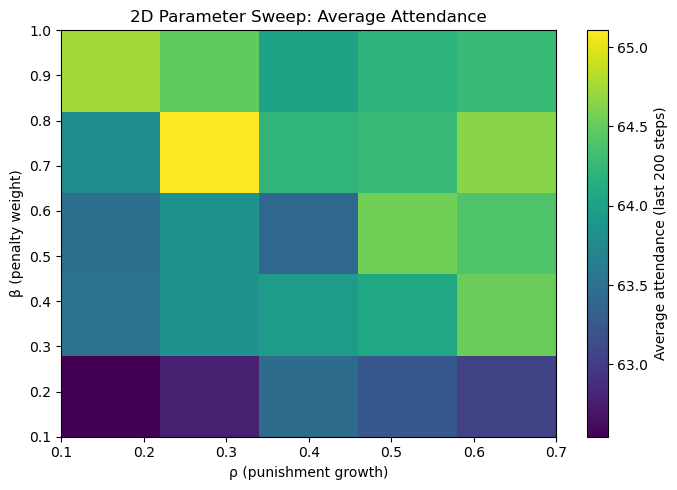

In [ ]:
def sweep_2d(param_x, values_x, param_y, values_y, summary_func, **base_kwargs):
    """
    Run 2D parameter sweep and return a matrix of summary statistics.

    Args:
        param_x, param_y: Names of parameters to vary
        values_x, values_y: Lists of parameter values
        summary_func: Function that takes simulation results and returns a single number
        base_kwargs: Default args for run_discrete_prob_rl

    Returns:
        np.ndarray of shape (len(values_y), len(values_x))
    """
    results = np.zeros((len(values_y), len(values_x)))
    for j, yval in enumerate(values_y):
        for i, xval in enumerate(values_x):
            kwargs = base_kwargs.copy()
            kwargs[param_x] = xval
            kwargs[param_y] = yval
            print(f"Running {param_x}={xval:.3f}, {param_y}={yval:.3f}")
            res = run_discrete_prob_rl(**kwargs)
            results[j, i] = summary_func(res)
    return results

def avg_attendance(res):
    return np.mean(res["attendance_ts"][-200:])  # average attendance over last 200 steps

def avg_payoff(res):
    return np.mean(res["avg_payoff_ts"][-200:])  # mean payoff in steady state

def avg_inactivity(res):
    # fraction of time agents are inactive near the end
    actions = (res["chosen_history"] > 0).astype(int)
    inactive = 1 - actions.mean(axis=1)
    return np.mean(inactive[-200:])

rho_values = np.linspace(0.1, 0.7, 5)
beta_values = np.linspace(0.1, 1.0, 5)


heatmap_data = sweep_2d("rho", rho_values, "beta", beta_values,
                        summary_func=avg_attendance,
                        N=N, C=C, T=500, M=M, lr=LR, gamma=GAMMA,
                        tau_start=TAU_START, tau_min=TAU_MIN,
                        alpha=alpha, bar_theta=bar_theta,
                        theta_cap=theta_cap, k_init=K_INIT)


plt.figure(figsize=(7, 5))
im = plt.imshow(heatmap_data, origin='lower', aspect='auto',
                extent=[rho_values[0], rho_values[-1], beta_values[0], beta_values[-1]],
                cmap='viridis')
plt.colorbar(im, label="Average attendance (last 200 steps)")
plt.xlabel("ρ (punishment growth)")
plt.ylabel("β (penalty weight)")
plt.title("2D Parameter Sweep: Average Attendance")
plt.tight_layout()
plt.show()





Running S=2.000, F=0.100
Running S=2.750, F=0.100
Running S=3.500, F=0.100
Running S=4.250, F=0.100
Running S=5.000, F=0.100
Running S=2.000, F=0.450
Running S=2.750, F=0.450
Running S=3.500, F=0.450
Running S=4.250, F=0.450
Running S=5.000, F=0.450
Running S=2.000, F=0.800
Running S=2.750, F=0.800
Running S=3.500, F=0.800
Running S=4.250, F=0.800
Running S=5.000, F=0.800
Running S=2.000, F=1.150
Running S=2.750, F=1.150
Running S=3.500, F=1.150
Running S=4.250, F=1.150
Running S=5.000, F=1.150
Running S=2.000, F=1.500
Running S=2.750, F=1.500
Running S=3.500, F=1.500
Running S=4.250, F=1.500
Running S=5.000, F=1.500


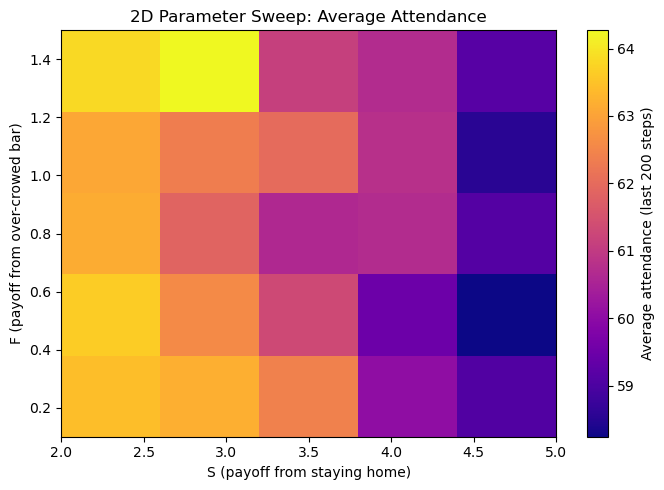

In [ ]:

heatmap_data_SF = sweep_2d("S", S_values, "F", F_values,
                        summary_func=avg_attendance, G=G,
                        N=N, C=C, T=500, M=M, lr=LR, gamma=GAMMA,
                        tau_start=TAU_START, tau_min=TAU_MIN, rho=rho,
                        alpha=alpha, beta=beta, bar_theta=bar_theta,
                        theta_cap=theta_cap, k_init=K_INIT)

plt.figure(figsize=(7, 5))
im = plt.imshow(heatmap_data_SF, origin='lower', aspect='auto',
                extent=[S_values[0], S_values[-1], F_values[0], F_values[-1]],
                cmap='plasma')
plt.colorbar(im, label="Average attendance (last 200 steps)")
plt.xlabel("S (payoff from staying home)")
plt.ylabel("F (payoff from over-crowed bar)")
plt.title("2D Parameter Sweep: Average Attendance")
plt.tight_layout()
plt.show()

# Varianse

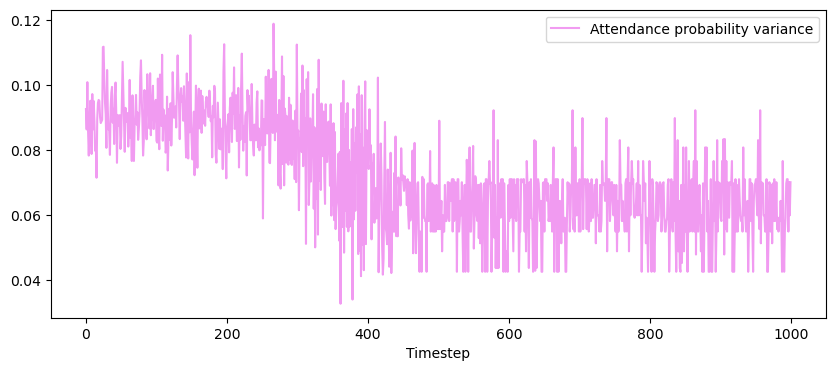

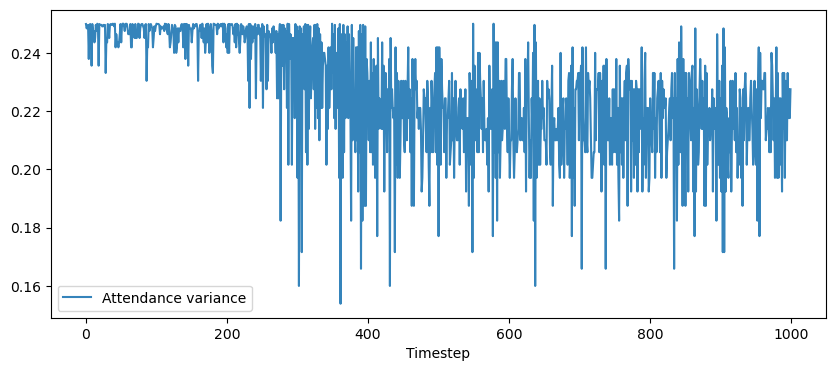

In [ ]:
t = np.arange(len(res["p_var"]))

plt.figure(figsize=(10,4))
plt.plot(t, res["p_var"], color = "violet", label="Attendance probability variance", alpha=0.8)
plt.xlabel("Timestep")
plt.legend()
plt.show()


plt.figure(figsize=(10,4))
plt.plot(t, res["attendance_var_ts"], label="Attendance variance", alpha=0.9)
plt.xlabel("Timestep")
plt.legend()
plt.show()

# Seed analysis

Running seed = 400
Running seed = 401
Running seed = 402
Running seed = 403
Running seed = 404
Running seed = 405
Running seed = 406
Running seed = 407
Running seed = 408
Running seed = 409
Running seed = 410
Running seed = 411
Running seed = 412
Running seed = 413
Running seed = 414
Running seed = 415
Running seed = 416
Running seed = 417
Running seed = 418
Running seed = 419


C:\Users\katja\AppData\Local\Temp\ipykernel_33620\2578792208.py:138: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_vals, mode_counts = _stats.mode(chosen_hist_stack, axis=0)


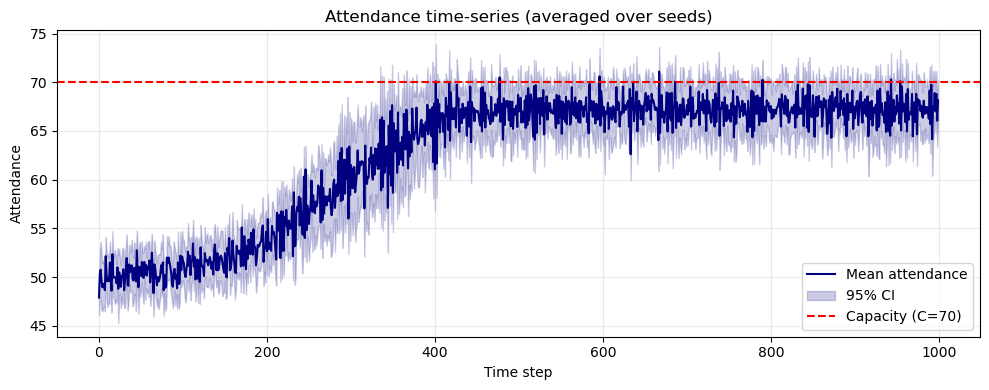

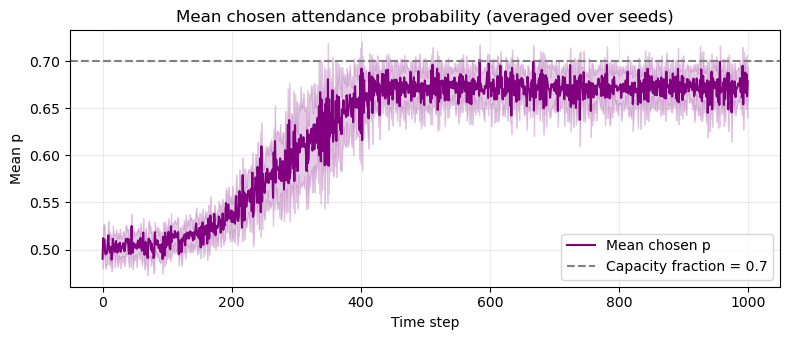

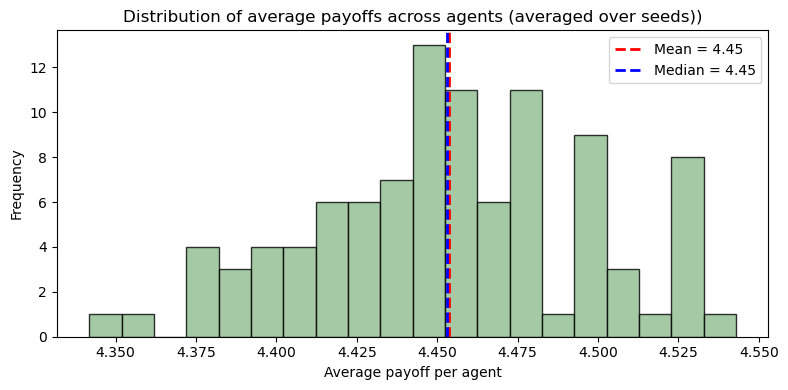

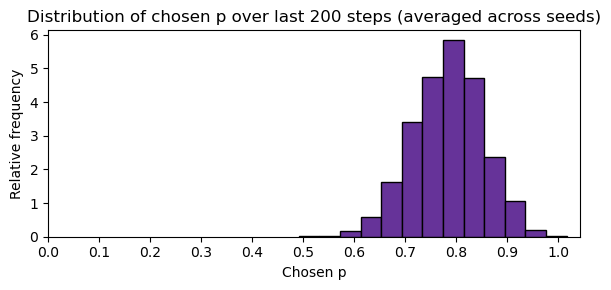

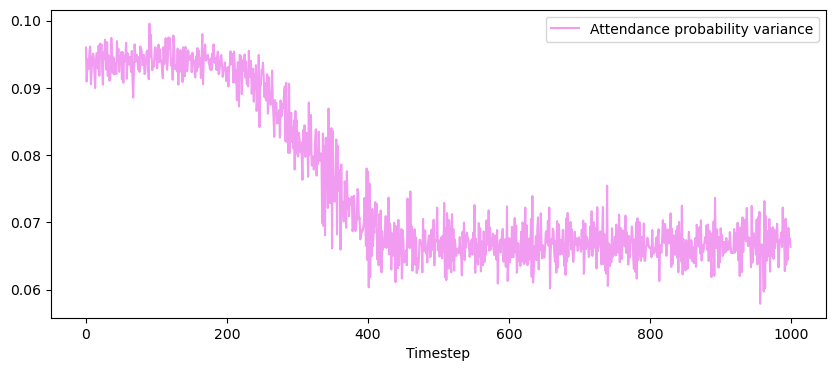

Running seed = 400
Running seed = 401
Running seed = 402
Running seed = 403
Running seed = 404
Running seed = 405
Running seed = 406
Running seed = 407
Running seed = 408
Running seed = 409
Running seed = 410
Running seed = 411
Running seed = 412
Running seed = 413
Running seed = 414
Running seed = 415
Running seed = 416
Running seed = 417
Running seed = 418
Running seed = 419


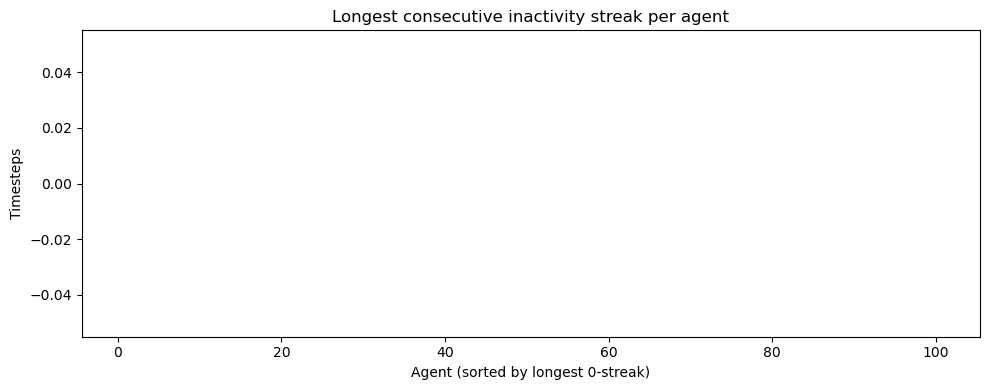

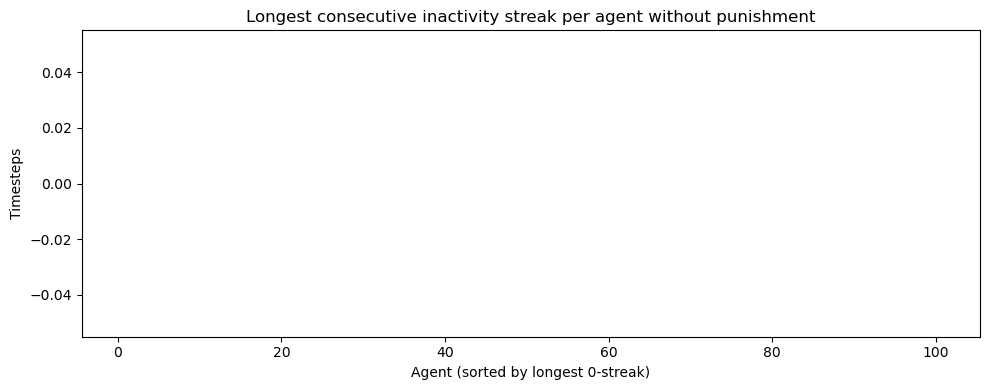

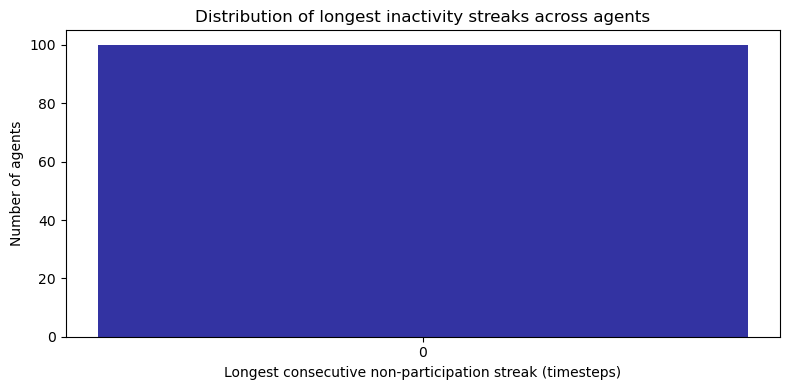

In [ ]:
def run_multiple_seeds_and_aggregate(
        run_func,
        seeds,
        # pass-through kwargs for your run_discrete_prob_rl
        **run_kwargs):
    """
    Run `run_func(SEED=seed, **run_kwargs)` for each seed in `seeds`
    and aggregate numeric outputs by mean (and optionally compute std/ci).
    
    Returns:
      runs: list of per-seed result dicts (original returns)
      agg: dict of aggregated results (mean across runs)
      stats: dict of standard errors and 95% CI for time-series arrays
    """
    runs = []
    for seed in seeds:
        print(f"Running seed = {seed}")
        r = run_func(SEED=seed, **run_kwargs)
        runs.append(r)

    # keys we expect to average (modify if your return dict differs)
    # scalar / 1D / 2D numpy arrays:
    avg_keys = [
        "attendance_ts",   # shape (T,)
        "mean_p_ts",       # shape (T,)
        "attendance_var_ts", # shape (T,)
        "avg_payoff_ts",   # shape (T,)
        "tau_history",     # shape (T,)
        "all_payoffs",     # shape (T, N)
        "chosen_action_counts", # shape (N, M+1)  (counts; averaging gives mean-counts)
        "chosen_history",  # shape (T, N)  (we'll average indices -> float)
        "final_theta",     # shape (N,)
        "p_var"            # if present
    ]

    # collect arrays by key, stacking where possible
    stacked = {}
    for k in avg_keys:
        vals = []
        for r in runs:
            if k in r:
                vals.append(np.asarray(r[k]))
        if len(vals) == 0:
            # key absent in all runs -> skip
            continue
        # ensure all shapes match
        shapes = [v.shape for v in vals]
        if not all(s == shapes[0] for s in shapes):
            raise ValueError(f"Shape mismatch for key {k}: {shapes}")
        stacked[k] = np.stack(vals, axis=0)  # shape (R, ...) where R = len(seeds)

    # Aggregate by mean across runs (axis=0)
    agg = {}
    for k, arr in stacked.items():
        agg[k] = arr.mean(axis=0)

    # Keep the raw per-run Q-tables and full runs
    runs_qtables = [r.get("final_Q_tables", None) for r in runs]
    agg["runs_qtables"] = runs_qtables
    agg["runs_raw"] = runs  # optional: keep full list if you want to inspect later

    # Compute standard error and 95% CI for time-series arrays (useful for plotting)
    stats = {}
    from scipy import stats as _stats  # optional; for t-interval
    R = stacked[next(iter(stacked))].shape[0]  # number of runs

    for k, arr in stacked.items():
        # arr shape (R, ...)
        mean = arr.mean(axis=0)
        std = arr.std(axis=0, ddof=1) if R > 1 else np.zeros_like(mean)
        se = std / np.sqrt(R) if R > 1 else np.zeros_like(mean)

        # 95% CI using t distribution
        if R > 1:
            tval = _stats.t.ppf(0.975, df=R-1)
            ci_low = mean - tval * se
            ci_high = mean + tval * se
        else:
            ci_low = mean.copy()
            ci_high = mean.copy()

        stats[k] = {
            "mean": mean,
            "std": std,
            "se": se,
            "ci95_low": ci_low,
            "ci95_high": ci_high,
            "R": R
        }

    return runs, agg, stats

# -------------------------
# Example usage:
# -------------------------
# suppose your run_discrete_prob_rl is defined and imported in the notebook and
# accepts keyword SEED plus the other usual parameters (G,S,F,...).
# We'll run it for 10 seeds:
seeds = list(range(400, 420))   # or choose any list of 10 seeds

runs, agg, stats = run_multiple_seeds_and_aggregate(
    run_discrete_prob_rl,
    seeds,
    G=G, S=S, F=F, N=N, C=C, T=T, M=M, lr=LR, gamma=GAMMA,
    tau_start=TAU_START, tau_min=TAU_MIN,
    rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
    theta_cap=theta_cap, k_init=K_INIT
)

# -------------------------
# How to use aggregated results:
# -------------------------
# 1) Time series mean:
attendance_mean = agg["attendance_ts"]   # shape (T,)
mean_p_mean = agg["mean_p_ts"]           # shape (T,)

# 2) Per-time-step 95% CI (for plotting shaded bands)
att_ci_low = stats["attendance_ts"]["ci95_low"]
att_ci_high = stats["attendance_ts"]["ci95_high"]

# 3) Average payoff per agent across runs:
#    agg["all_payoffs"] is average (over seeds) of the (T,N) arrays.
#    you can compute agent-level average payoffs across time and seeds:
agent_avg_payoff_across_runs = agg["all_payoffs"].mean(axis=0)  # shape (N,)
# or compute mean over agents -> global mean payoff per time step across runs:
avg_payoff_ts_mean = agg["avg_payoff_ts"]  # shape (T,)

# 4) chosen_history mean:
chosen_idx_mean = agg["chosen_history"]  # shape (T, N), floats (mean chosen index per agent per timestep)

# 5) If you want the mode (most common chosen index) across runs for chosen_history:
from scipy import stats as _stats
# stacked["chosen_history"].shape == (R, T, N)
chosen_hist_stack = np.stack([r["chosen_history"] for r in runs], axis=0)  # (R, T, N)
# compute mode across runs for each (t,i)
mode_vals, mode_counts = _stats.mode(chosen_hist_stack, axis=0)
mode_vals = mode_vals.squeeze(0)  # shape (T, N)

# 6) If you need to save aggregated results:
import pickle
with open("aggregated_results.pkl", "wb") as f:
    pickle.dump({"runs": runs, "agg": agg, "stats": stats}, f)


# === 1) Attendance time-series (averaged across seeds) ===
att_rl = agg["attendance_ts"]          # shape (T,)
att_low = stats["attendance_ts"]["ci95_low"]
att_high = stats["attendance_ts"]["ci95_high"]

plt.figure(figsize=(10, 4))
plt.plot(att_rl, label="Mean attendance", color="navy")

# Optional: add 95% CI shading
plt.fill_between(np.arange(len(att_rl)), att_low, att_high,
                 alpha=0.2, color="navy", label="95% CI")

plt.axhline(C, color='r', linestyle='--', label=f'Capacity (C={C})')
plt.title("Attendance time-series (averaged over seeds)")
plt.xlabel("Time step")
plt.ylabel("Attendance")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# === 2) Mean chosen p time-series (averaged across seeds) ===
mean_p = agg["mean_p_ts"]
p_low = stats["mean_p_ts"]["ci95_low"]
p_high = stats["mean_p_ts"]["ci95_high"]

plt.figure(figsize=(8, 3.5))
plt.plot(mean_p, label='Mean chosen p', color='purple')

# Optional CI shading
plt.fill_between(np.arange(len(mean_p)), p_low, p_high,
                 alpha=0.2, color='purple')

plt.axhline(C_frac, color='gray', linestyle='--', label=f'Capacity fraction = {C_frac}')
plt.title("Mean chosen attendance probability (averaged over seeds)")
plt.xlabel("Time step")
plt.ylabel("Mean p")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()




# -------
# Compute each agent’s average payoff over the full run
agent_avg_payoffs = agg["all_payoffs"].mean(axis=0)

mean_val = agent_avg_payoffs.mean()
median_val = np.median(agent_avg_payoffs)

plt.figure(figsize=(8, 4))
plt.hist(agent_avg_payoffs, bins=20, color="darkseagreen", edgecolor="black", alpha=0.8)

# --- Add mean and median lines ---
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color="blue", linestyle="--", linewidth=2, label=f"Median = {median_val:.2f}")

plt.xlabel("Average payoff per agent")
plt.ylabel("Frequency")
plt.title("Distribution of average payoffs across agents (averaged over seeds))")
plt.legend()
plt.tight_layout()
plt.show()





# === 3) Histogram of p over final window (averaged over seeds) ===

chosen_hist_avg = agg["chosen_history"]   # shape (T, N), float 
final_window = 200
w = min(final_window, chosen_hist_avg.shape[0])
# Convert averaged indices back to p-values
# Note: these are *averaged* chosen indices, not raw samples
M = int(np.round(chosen_hist_avg.max()))  # max discrete value

p_values = chosen_hist_avg[-w:, :].flatten() / M

plt.figure(figsize=(6, 3))
plt.hist(p_values,
         bins=M+1,
         edgecolor='black',
         color='rebeccapurple',
         density=True)

plt.title(f"Distribution of chosen p over last {w} steps (averaged across seeds)")
plt.xlabel("Chosen p")
plt.ylabel("Relative frequency")
plt.xticks(np.linspace(0, 1, 11))
plt.tight_layout()
plt.show()




t_agg = np.arange(len(agg["p_var"]))

plt.figure(figsize=(10,4))
plt.plot(t_agg, agg["p_var"], color = "violet", label="Attendance probability variance", alpha=0.8)
plt.xlabel("Timestep")
plt.legend()
plt.show()



#avg is never zero - so non attendance plots need new code 






Running 10 seeds...
 Running seed 400 (1/10)
 Running seed 401 (2/10)
 Running seed 402 (3/10)
 Running seed 403 (4/10)
 Running seed 404 (5/10)
 Running seed 405 (6/10)
 Running seed 406 (7/10)
 Running seed 407 (8/10)
 Running seed 408 (9/10)
 Running seed 409 (10/10)


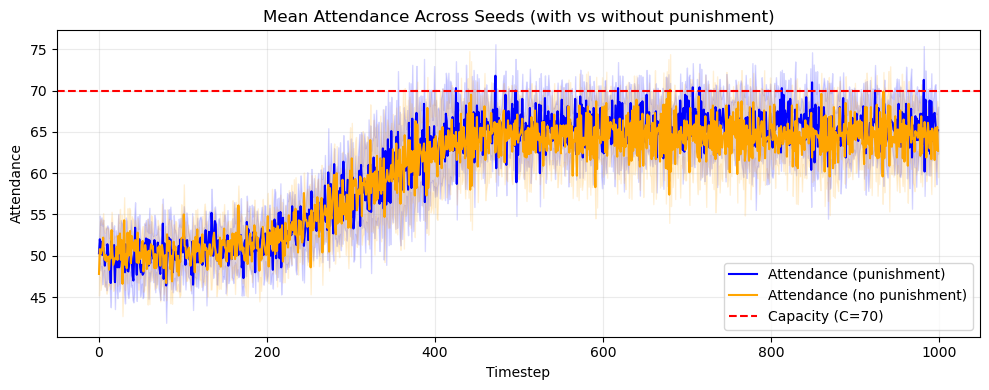

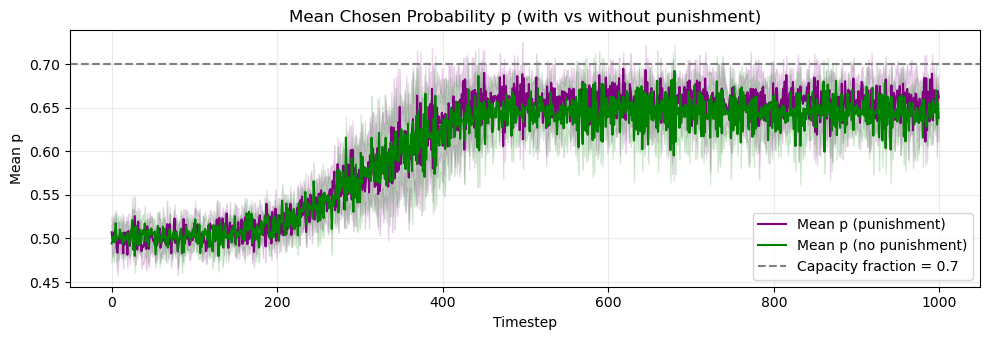

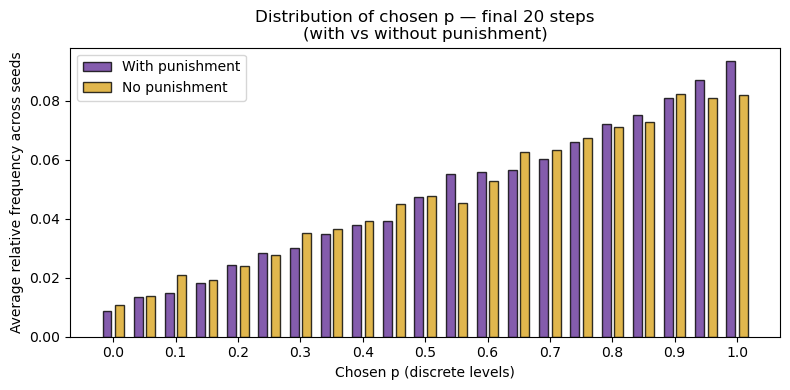

In [489]:
# --- parameters for the sweep ---
num_seeds = 10
start_seed = 400   # change if you want a different block of seeds
T_run = 1000        # must match the T you pass to run_discrete_prob_rl
final_window = 20    # number of final timesteps to gather chosen indices for hist

# storage
attendance_all = np.zeros((num_seeds, T_run))
mean_p_all = np.zeros((num_seeds, T_run))
tau_history_all = np.zeros((num_seeds, T_run))
# For averaged discrete histogram: we'll collect per-seed normalized counts over M+1 bins
hist_per_seed = np.zeros((num_seeds, M + 1))

# storage - NO PUNISHMENT
attendance_all_nopun = np.zeros((num_seeds, T_run))
mean_p_all_nopun = np.zeros((num_seeds, T_run))
tau_history_all_nopun = np.zeros((num_seeds, T_run))

# For averaged discrete histogram: we'll collect per-seed normalized counts over M+1 bins
hist_per_seed_nopun = np.zeros((num_seeds, M + 1))

print("Running {} seeds...".format(num_seeds))
for si, seed in enumerate(range(start_seed, start_seed + num_seeds)):
    print(f" Running seed {seed} ({si+1}/{num_seeds})")

    res_seed = run_discrete_prob_rl(G=6, S=S, F=F, N=N, C=C, T=T_run, M=M, lr=LR, gamma=GAMMA, 
                                    tau_start=TAU_START, tau_min=TAU_MIN,
                                    rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                                    theta_cap=theta_cap, k_init=K_INIT, SEED=seed)

    res_seed_nopun = run_discrete_prob_rl(G=6, S=S, F=F, N=N, C=C, T=T_run, M=M, lr=LR, gamma=GAMMA, 
                                    tau_start=TAU_START, tau_min=TAU_MIN,
                                    rho=rho, alpha=alpha, beta=0, bar_theta=bar_theta,
                                    theta_cap=theta_cap, k_init=K_INIT, SEED=seed)
    
    # ensure shapes match
    att = res_seed["attendance_ts"]
    mp = res_seed["mean_p_ts"]
    th = res_seed["tau_history"]

    att_nopun = res_seed_nopun["attendance_ts"]
    mp_nopun = res_seed_nopun["mean_p_ts"]
    th_nopun = res_seed_nopun["tau_history"]


    # T_run might equal len(att); if not, take min
    L = min(T_run, len(att))
    attendance_all[si, :L] = att[:L]
    mean_p_all[si, :L] = mp[:L]
    tau_history_all[si, :L] = th[:L]

    attendance_all_nopun[si, :L] = att_nopun[:L]
    mean_p_all_nopun[si, :L] = mp_nopun[:L]
    tau_history_all_nopun[si, :L] = th_nopun[:L]


    # final-window chosen indices -> histogram counts (discrete bins 0..M)
    chosen_hist = res_seed["chosen_history"]
    w = min(final_window, chosen_hist.shape[0])
    flat_idxs = chosen_hist[-w:, :].flatten()            # values in {0,...,M}
    counts = np.bincount(flat_idxs, minlength=M+1)       # length M+1
    # normalize to per-seed probability mass (so each seed contributes equally)
    if counts.sum() > 0:
        hist_per_seed[si, :] = counts / counts.sum()
    else:
        hist_per_seed[si, :] = np.zeros(M + 1)

    # NO PUNISHMENT
    chosen_hist_nopun = res_seed_nopun["chosen_history"]
    w_nopun = min(final_window, chosen_hist_nopun.shape[0])
    flat_idxs_nopun = chosen_hist_nopun[-w:, :].flatten()            # values in {0,...,M}
    counts_nopun = np.bincount(flat_idxs_nopun, minlength=M+1)       # length M+1
    # normalize to per-seed probability mass (so each seed contributes equally)
    if counts_nopun.sum() > 0:
        hist_per_seed_nopun[si, :] = counts_nopun / counts_nopun.sum()
    else:
        hist_per_seed_nopun[si, :] = np.zeros(M + 1)

# --- compute means and 95% CIs across seeds ---

# WITH punishment
mean_att = attendance_all.mean(axis=0)
std_att  = attendance_all.std(axis=0, ddof=0)
ci_att   = 1.96 * std_att / np.sqrt(num_seeds)

mean_p   = mean_p_all.mean(axis=0)
std_p    = mean_p_all.std(axis=0, ddof=0)
ci_p     = 1.96 * std_p / np.sqrt(num_seeds)

mean_hist = hist_per_seed.mean(axis=0)

# NO punishment
mean_att_nopun = attendance_all_nopun.mean(axis=0)
std_att_nopun  = attendance_all_nopun.std(axis=0, ddof=0)
ci_att_nopun   = 1.96 * std_att_nopun / np.sqrt(num_seeds)

mean_p_nopun   = mean_p_all_nopun.mean(axis=0)
std_p_nopun    = mean_p_all_nopun.std(axis=0, ddof=0)
ci_p_nopun     = 1.96 * std_p_nopun / np.sqrt(num_seeds)

mean_hist_nopun = hist_per_seed_nopun.mean(axis=0)

bin_centers = np.arange(M + 1) / float(M)
t = np.arange(len(mean_att))


# ============================================================
# 1) Attendance with 95% CI – Punishment vs No Punishment
# ============================================================

plt.figure(figsize=(10, 4))

# WITH punishment
plt.plot(t, mean_att, label="Attendance (punishment)", color="blue")
plt.fill_between(t, mean_att - ci_att, mean_att + ci_att,
                 color='blue', alpha=0.15)

# NO punishment
plt.plot(t, mean_att_nopun, label="Attendance (no punishment)", color="orange")
plt.fill_between(t, mean_att_nopun - ci_att_nopun, mean_att_nopun + ci_att_nopun,
                 color='orange', alpha=0.15)

plt.axhline(C, color='r', linestyle='--', label=f'Capacity (C={C})')

plt.xlabel("Timestep")
plt.ylabel("Attendance")
plt.title("Mean Attendance Across Seeds (with vs without punishment)")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()



# ============================================================
# 2) Mean chosen p with CI
# ============================================================

plt.figure(figsize=(10, 3.5))

# WITH punishment
plt.plot(t, mean_p, color='purple', label="Mean p (punishment)")
plt.fill_between(t, mean_p - ci_p, mean_p + ci_p, color='purple', alpha=0.15)

# NO punishment
plt.plot(t, mean_p_nopun, color='green', label="Mean p (no punishment)")
plt.fill_between(t, mean_p_nopun - ci_p_nopun, mean_p_nopun + ci_p_nopun,
                 color='green', alpha=0.15)

plt.axhline(C_frac, color='gray', linestyle='--', label=f'Capacity fraction = {C_frac}')

plt.xlabel("Timestep")
plt.ylabel("Mean p")
plt.title("Mean Chosen Probability p (with vs without punishment)")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()



# ============================================================
# 3) Final-window histogram comparison
# ============================================================

plt.figure(figsize=(8, 4))

bar_width = 0.3 / (M + 1)

plt.bar(bin_centers - 0.01 , mean_hist,
        width=bar_width, edgecolor='black',
        color='rebeccapurple', alpha=0.8, label="With punishment")

plt.bar(bin_centers + 0.01, mean_hist_nopun,
        width=bar_width, edgecolor='black',
        color='goldenrod', alpha=0.8, label="No punishment")

plt.xlabel("Chosen p (discrete levels)")
plt.ylabel("Average relative frequency across seeds")
plt.title(f"Distribution of chosen p — final {final_window} steps\n(with vs without punishment)")
plt.xticks(np.linspace(0, 1, 11))
plt.legend()
plt.tight_layout()
plt.show()



# Q-table values 

Showing how the q-values changes when the agents have a single period of memory

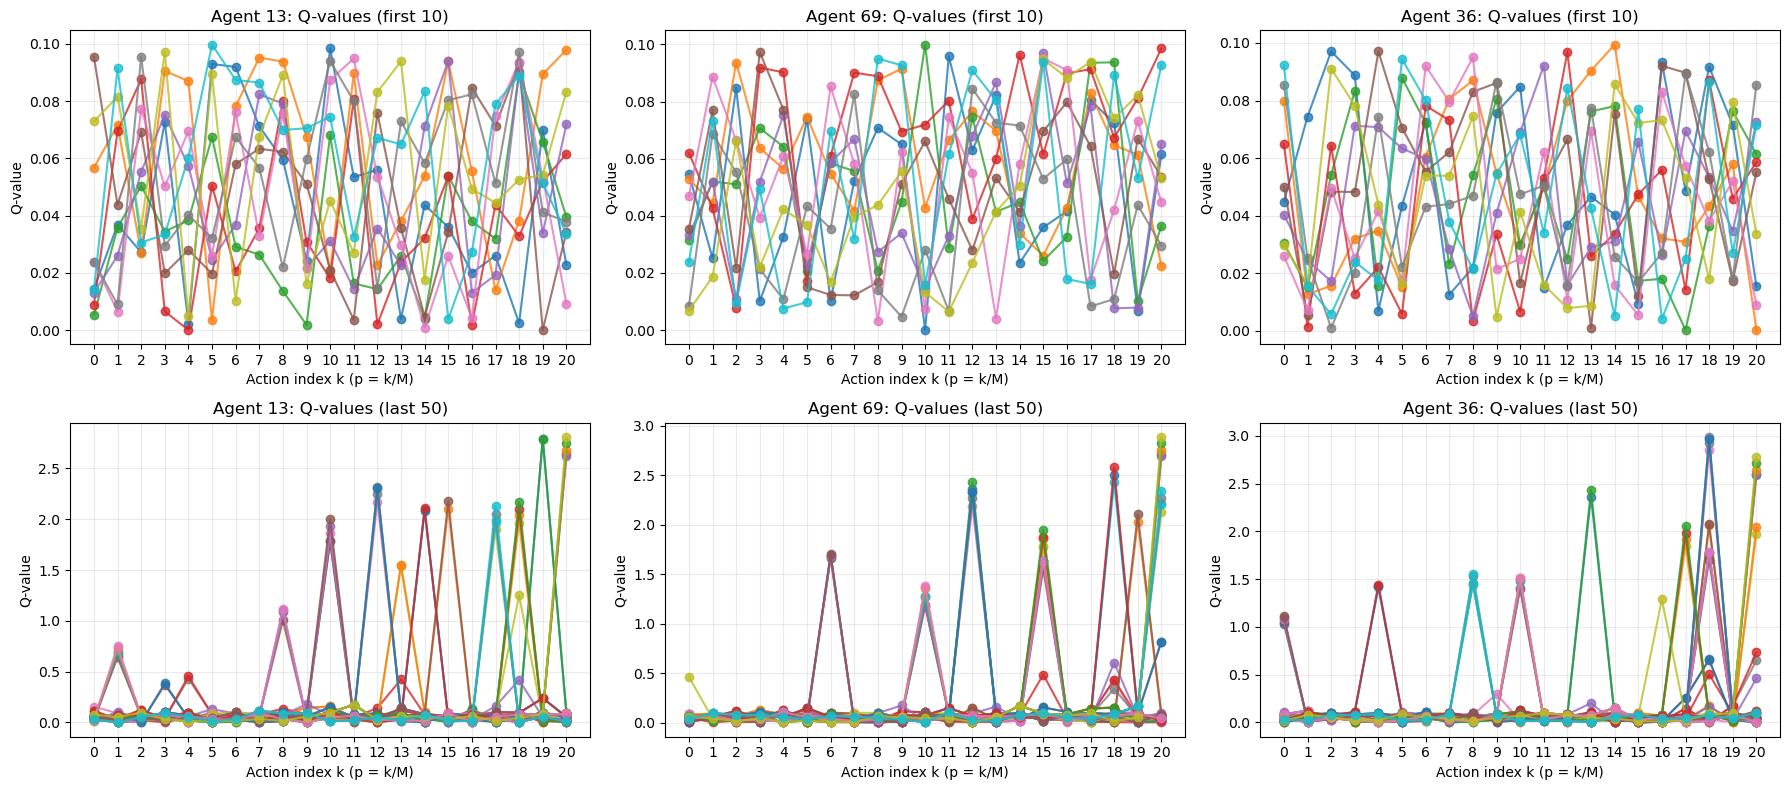

In [507]:
# Paste this cell below your existing definitions (softmax, make_state, etc.)
# It reuses your parameters and q_get logic but instruments Q snapshots for one agent.

def run_with_q_snapshots(agent_idx=0, T_record_first=10, T_record_last=10, **kwargs):
    """
    Run the discrete-prob RL but record the specified agent's Q-vector
    (for the state encountered at each timestep) before each Q update.

    Returns the usual result dict plus:
      - q_snapshots: list of q-vectors (length T), each shape (M+1,)
      - state_seq: list of states encountered at each timestep (len T)
    """
    # Pull parameters from kwargs or fall back to globals you defined
    G = kwargs.get("G", globals().get("G"))
    S = kwargs.get("S", globals().get("S"))
    F = kwargs.get("F", globals().get("F"))
    N = kwargs.get("N", globals().get("N"))
    C = kwargs.get("C", globals().get("C"))
    T = kwargs.get("T", globals().get("T"))
    M = kwargs.get("M", globals().get("M"))
    lr = kwargs.get("lr", globals().get("LR"))
    gamma = kwargs.get("gamma", globals().get("GAMMA"))
    tau_start = kwargs.get("tau_start", globals().get("TAU_START"))
    tau_min = kwargs.get("tau_min", globals().get("TAU_MIN"))
    rho = kwargs.get("rho", globals().get("rho"))
    alpha = kwargs.get("alpha", globals().get("alpha"))
    beta = kwargs.get("beta", globals().get("beta"))
    bar_theta = kwargs.get("bar_theta", globals().get("bar_theta"))
    theta_cap = kwargs.get("theta_cap", globals().get("theta_cap"))
    k_init = kwargs.get("k_init", globals().get("K_INIT"))
    SEED = kwargs.get("SEED", globals().get("SEED"))

    np.random.seed(SEED)

    # initialize as in your function
    Q_tables = [dict() for _ in range(N)]
    last_actual = np.random.binomial(1, 0.5, size=N)
    theta_i = np.array([bar_theta if a == 0 else 0.0 for a in last_actual], dtype=float)

    def q_get_local(qdict, s):
        if s not in qdict:
            qdict[s] = np.random.uniform(0, k_init, size=M + 1)
        return qdict[s]

    attendance_ts = []
    chosen_history = np.zeros((T, N), dtype=int)
    avg_payoff_ts = []
    all_payoffs = np.zeros((T, N))
    tau_history = []

    # snapshots for the inspected agent (one q-vector per timestep)
    q_snapshots = [None] * T
    state_seq = [None] * T

    # decay
    TAU_DECAY = -math.log(tau_min / tau_start) / max(1, (T - 1))

    for t in range(T):
        tau_t = max(tau_min, tau_start * math.exp(-TAU_DECAY * t))
        tau_history.append(tau_t)

        A_prev = attendance_ts[-1] if t > 0 else int(N * 0.1)
        state = make_state(A_prev)

        state_seq[t] = state  # record state used at this timestep

        actions = np.zeros(N, dtype=int)
        chosen_idxs = np.zeros(N, dtype=int)

        # --- action selection ---
        for i in range(N):
            qvec = q_get_local(Q_tables[i], state)
            probs = softmax(qvec, tau=tau_t)
            if np.any(np.isnan(probs)) or probs.sum() <= 0:
                probs = np.ones(M + 1) / (M + 1)
            idx = np.random.choice(np.arange(M + 1), p=probs)
            chosen_idxs[i] = int(idx)

        # Map chosen idx -> Bernoulli p and sample actions
        p_vec = chosen_idxs / float(M)
        for i in range(N):
            actions[i] = np.random.binomial(1, p_vec[i])

        chosen_history[t, :] = chosen_idxs
        A_t = actions.sum()
        attendance_ts.append(A_t)

        # --- BEFORE updating Q: snapshot the inspected agent's Q-vector for this state ---
        qvec_agent = q_get_local(Q_tables[agent_idx], state)  # ensures it exists
        q_snapshots[t] = qvec_agent.copy()

        # update theta
        new_theta = np.zeros_like(theta_i)
        for i in range(N):
            if actions[i] == 0 and last_actual[i] == 0:
                prev = theta_i[i] if theta_i[i] > 0 else bar_theta
                new_val = prev + rho * (prev ** alpha)
                new_theta[i] = min(new_val, theta_cap)
            elif actions[i] == 0 and last_actual[i] == 1:
                new_theta[i] = bar_theta
            else:
                new_theta[i] = 0.0
        theta_i = new_theta

        # rewards
        rewards = np.zeros(N, dtype=float)
        for i in range(N):
            if actions[i] == 1:
                others = A_t - 1
                payoff = G if others < C else F
            else:
                payoff = S
            rewards[i] = payoff - beta * theta_i[i]
        avg_payoff_ts.append(rewards.mean())
        all_payoffs[t, :] = rewards

        # --- Q-learning update (as in your function) ---
        next_state = make_state(A_t)
        for i in range(N):
            qdict = Q_tables[i]
            qvec = q_get_local(qdict, state)
            next_qvec = q_get_local(qdict, next_state)
            aidx = chosen_idxs[i]
            r = rewards[i]
            qvec[aidx] += lr * (r + gamma * np.max(next_qvec) - qvec[aidx])
            qdict[state] = qvec

        last_actual = actions.copy()

    # done
    result = {
        "attendance_ts": np.array(attendance_ts),
        "mean_p_ts": np.array([np.mean(chosen_history[t]/float(M)) for t in range(T)]),
        "chosen_history": chosen_history,
        "final_Q_tables": Q_tables,
        "q_snapshots": q_snapshots,
        "state_seq": state_seq,
        "avg_payoff_ts": np.array(avg_payoff_ts),
        "all_payoffs": all_payoffs,
        "tau_history": np.array(tau_history)
    }
    return result


# ---------------------------
# Run the instrumented simulation and plot the chosen agent's Q-values
# ---------------------------
agent_to_inspect = 69  
agent_to_inspect_2 = 13
agent_to_inspect_3 = 36 # much unattance in plot
res_snap = run_with_q_snapshots(agent_idx=agent_to_inspect, G=G, S=S, F=F, N=N, C=C, T=T, M=M,
                                lr=LR, gamma=GAMMA, tau_start=TAU_START, tau_min=TAU_MIN,
                                rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                                theta_cap=theta_cap, k_init=K_INIT, SEED=SEED)

q_snaps = res_snap["q_snapshots"]  # list length T of q-vectors (each length M+1)
state_seq = res_snap["state_seq"]

res_snap_2 = run_with_q_snapshots(agent_idx=agent_to_inspect_2, G=G, S=S, F=F, N=N, C=C, T=T, M=M,
                                lr=LR, gamma=GAMMA, tau_start=TAU_START, tau_min=TAU_MIN,
                                rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                                theta_cap=theta_cap, k_init=K_INIT, SEED=SEED)

q_snaps_2 = res_snap_2["q_snapshots"]  
state_seq_2 = res_snap_2["state_seq"]

res_snap_3= run_with_q_snapshots(agent_idx=agent_to_inspect_3, G=G, S=S, F=F, N=N, C=C, T=T, M=M,
                                lr=LR, gamma=GAMMA, tau_start=TAU_START, tau_min=TAU_MIN,
                                rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                                theta_cap=theta_cap, k_init=K_INIT, SEED=SEED)

q_snaps_3 = res_snap_3["q_snapshots"]
state_seq_3 = res_snap_3["state_seq"]

# Print numeric Q-vectors for first 10 and last 10 periods
first_k = 10
last_k = 50

# ---------- PLOTTING ----------


x = np.arange(M+1)

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.ravel()   # flatten for easier indexing

# ---- Helper function to plot Q-value overlays ----
def plot_q_overlay(ax, q_snaps, title, first=True):
    if first:
        timesteps = range(min(first_k, T))
    else:
        timesteps = range(max(0, T-last_k), T)

    for t in timesteps:
        ax.plot(x, q_snaps[t], marker='o', alpha=0.8)

    ax.set_xlabel("Action index k (p = k/M)")
    ax.set_ylabel("Q-value")
    ax.set_title(title)
    if len(x) <= 21:
        ax.set_xticks(x)
    else:
        ax.set_xticks(np.linspace(0, M, 11).astype(int))
    ax.grid(alpha=0.25)

# ---- 1: Agent 1 first ----
plot_q_overlay(
    axes[0],
    q_snaps_2,
    f"Agent {agent_to_inspect_2}: Q-values (first {first_k})",
    first=True
)

# ---- 2: Agent 2 first ----
plot_q_overlay(
    axes[1],
    q_snaps,
    f"Agent {agent_to_inspect}: Q-values (first {first_k})",
    first=True
)

# ---- 3: Agent 3 first ----
plot_q_overlay(
    axes[2],
    q_snaps_3,
    f"Agent {agent_to_inspect_3}: Q-values (first {first_k})",
    first=True
)

# ---- 4: Agent 1 last ----
plot_q_overlay(
    axes[3],
    q_snaps_2,
    f"Agent {agent_to_inspect_2}: Q-values (last {last_k})",
    first=False
)

# ---- 5: Agent 2 last ----
plot_q_overlay(
    axes[4],
    q_snaps,
    f"Agent {agent_to_inspect}: Q-values (last {last_k})",
    first=False
)

# ---- 6: Agent 3 last ----
plot_q_overlay(
    axes[5],
    q_snaps_3,
    f"Agent {agent_to_inspect_3}: Q-values (last {last_k})",
    first=False
)

plt.tight_layout()
plt.show()




Running 20 seeds...
 Running seed 400 (1/20)
 Running seed 401 (2/20)
 Running seed 402 (3/20)
 Running seed 403 (4/20)
 Running seed 404 (5/20)
 Running seed 405 (6/20)
 Running seed 406 (7/20)
 Running seed 407 (8/20)
 Running seed 408 (9/20)
 Running seed 409 (10/20)
 Running seed 410 (11/20)
 Running seed 411 (12/20)
 Running seed 412 (13/20)
 Running seed 413 (14/20)
 Running seed 414 (15/20)
 Running seed 415 (16/20)
 Running seed 416 (17/20)
 Running seed 417 (18/20)
 Running seed 418 (19/20)
 Running seed 419 (20/20)


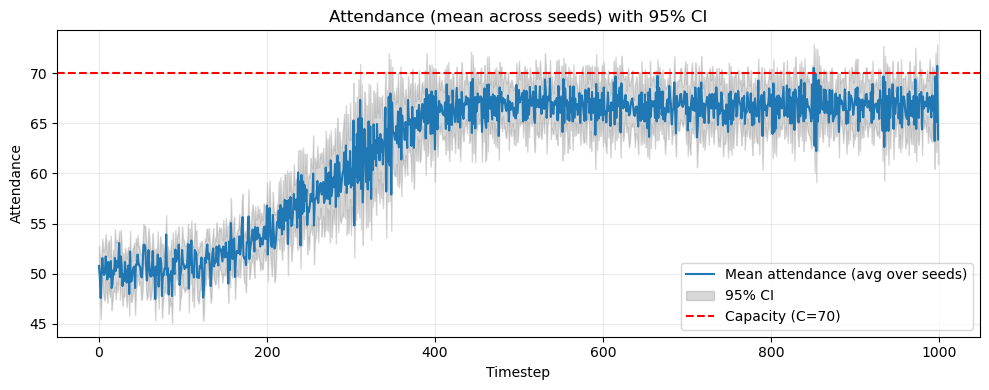

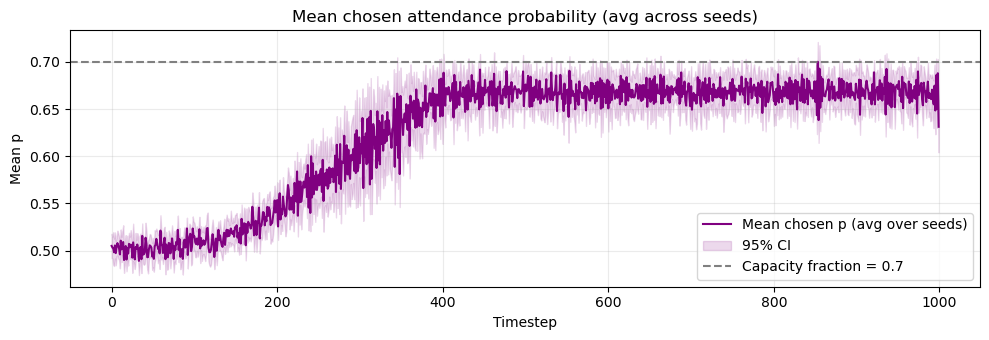

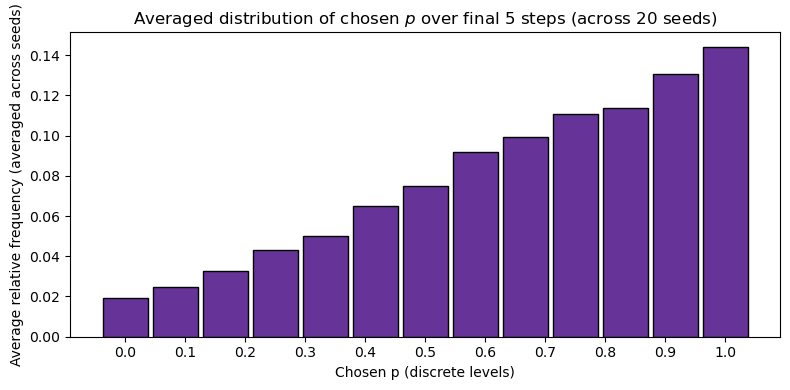

In [ ]:
# --- parameters for the sweep ---
num_seeds = 20
start_seed = 400   # change if you want a different block of seeds
T_run = 1000        # must match the T you pass to run_discrete_prob_rl
final_window = 5    # number of final timesteps to gather chosen indices for hist

# storage
attendance_all = np.zeros((num_seeds, T_run))
mean_p_all = np.zeros((num_seeds, T_run))
tau_history_all = np.zeros((num_seeds, T_run))
# For averaged discrete histogram: we'll collect per-seed normalized counts over M+1 bins
hist_per_seed = np.zeros((num_seeds, M + 1))

print("Running {} seeds...".format(num_seeds))
for si, seed in enumerate(range(start_seed, start_seed + num_seeds)):
    print(f" Running seed {seed} ({si+1}/{num_seeds})")

    res_seed = run_discrete_prob_rl(G=G, S=S, F=F, N=N, C=C, T=T_run, M=M, lr=LR, gamma=GAMMA, 
                                    tau_start=TAU_START, tau_min=TAU_MIN,
                                    rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                                    theta_cap=theta_cap, k_init=K_INIT, SEED=seed)

    res_seed_nopun = run_discrete_prob_rl(G=G, S=S, F=F, N=N, C=C, T=T_run, M=M, lr=LR, gamma=GAMMA, 
                                    tau_start=TAU_START, tau_min=TAU_MIN,
                                    rho=rho, alpha=alpha, beta=0, bar_theta=bar_theta,
                                    theta_cap=theta_cap, k_init=K_INIT, SEED=seed)
    
    # ensure shapes match
    att = res_seed["attendance_ts"]
    mp = res_seed["mean_p_ts"]
    th = res_seed["tau_history"]
    # T_run might equal len(att); if not, take min
    L = min(T_run, len(att))
    attendance_all[si, :L] = att[:L]
    mean_p_all[si, :L] = mp[:L]
    tau_history_all[si, :L] = th[:L]

    # final-window chosen indices -> histogram counts (discrete bins 0..M)
    chosen_hist = res_seed["chosen_history"]
    w = min(final_window, chosen_hist.shape[0])
    flat_idxs = chosen_hist[-w:, :].flatten()            # values in {0,...,M}
    counts = np.bincount(flat_idxs, minlength=M+1)       # length M+1
    # normalize to per-seed probability mass (so each seed contributes equally)
    if counts.sum() > 0:
        hist_per_seed[si, :] = counts / counts.sum()
    else:
        hist_per_seed[si, :] = np.zeros(M + 1)

# --- compute means and 95% CIs across seeds ---
mean_att = attendance_all.mean(axis=0)
std_att  = attendance_all.std(axis=0, ddof=0)
ci_att   = 1.96 * std_att / np.sqrt(num_seeds)

mean_p   = mean_p_all.mean(axis=0)
std_p    = mean_p_all.std(axis=0, ddof=0)
ci_p     = 1.96 * std_p / np.sqrt(num_seeds)

# averaged histogram across seeds
mean_hist = hist_per_seed.mean(axis=0)   # average density per bin across seeds
bin_centers = np.arange(M + 1) / float(M)

# --- PLOTS ---
# 1) Attendance with 95% CI
plt.figure(figsize=(10, 4))
t = np.arange(len(mean_att))
plt.plot(t, mean_att, label="Mean attendance (avg over seeds)")
plt.fill_between(t, mean_att - ci_att, mean_att + ci_att, color='gray', alpha=0.3,
                 label="95% CI")
plt.axhline(C, color='r', linestyle='--', label=f'Capacity (C={C})')
plt.xlabel("Timestep")
plt.ylabel("Attendance")
plt.title("Attendance (mean across seeds) with 95% CI")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# 2) Mean chosen p with 95% CI
plt.figure(figsize=(10, 3.5))
plt.plot(t, mean_p, color='purple', label="Mean chosen p (avg over seeds)")
plt.fill_between(t, mean_p - ci_p, mean_p + ci_p, color='purple', alpha=0.15,
                 label="95% CI")
plt.axhline(C_frac, color='gray', linestyle='--', label=f'Capacity fraction = {C_frac}')
plt.xlabel("Timestep")
plt.ylabel("Mean p")
plt.title("Mean chosen attendance probability (avg across seeds)")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# 3) Averaged discrete histogram of chosen p (final window)
plt.figure(figsize=(8, 4))

# Convert relative frequency to average number of agents
avg_count = mean_hist * N

# Each p-bin bar should still cover one discrete action width (1/M)
bar_width = (1.0 / M) * 0.9  

plt.bar(
    bin_centers,
    avg_count,
    width=bar_width,
    edgecolor='black',
    color='rebeccapurple',
    align='center'
)

plt.xlabel("Chosen $p$ (discrete levels)") 
plt.ylabel("Average number of agents (across seeds)")
plt.title(
    f"Averaged distribution of chosen $p$ over final {final_window} steps\n(across {num_seeds} seeds)"
)

plt.xticks(np.linspace(0, 1, 11))
plt.tight_layout()
plt.show()
